# XMM-Newton pySAS Pipeline for EPIC Imaging Processing and Spectral Extraction
<hr style="border: 2px solid #fadbac" />

- **Description:** An end-to-end data processing pipeline for XMM-Newton EPIC imaging. This pipeline tutorial combines all of the lessons from the XMM-Newton ABC and ESA Guides into a one-stop-shop tutorial and ready-to-use tool. This tutorial also walks the user through a science case involving the indentification of a new X-ray transient in NGC 4945.
- **Level:** Intermediate
- **Data:** XMM-Newton observation of NGC 4945 (obsid = 0903540101)
- **Requirements:** If running on Fornax, must use the X imaging. If running Sciserver, must use the X image. If running locally, ensure `heasoft` v.X.X.X and SAS vX.X.X are installed (follow the installation instructions on X and X), and ensure the following python packages are installed: [`heasoftpy`, `astropy`, `numpy`,`matplotlib`,`pysas`]. 
- **Credit:** Ryan W. Pfeifle (July 2025), with pySAS commands build using resources from Ryan Tanner
- **Support:** Contact Ryan W. Pfeifle
- **Last verified to run:** 09/12/2025

<hr style="border: 2px solid #fadbac" />

## 1. Introduction
Describe the content. It can contain plain text, bullets, and/or images as needed. 
Use `Markdown` when writing.

The following are suggested subsections. Not all are needed:
- Motivation / Science background.
- Learning goals.
- Details about the requirements, and on running the notebook outside Sciserver. 
- Type of outcome or end product.

This tutorial notebook builds upon the lessons and documentation found within the XMM-Newton pySAS Notebooks housed here in SciServer and on Fornax. For users new to pySAS and looking for more in-depth details on the inner workings and functionality of pySAS, we refer the user to the following Notebooks:
- Notebook one/two
- Notebook three
- Notebook four
- Notebook five

<a href='https://heasarc.gsfc.nasa.gov/docs/xmm/xmmhp_analysis.html#docs'>And these same step or similar are discussed for standard SAS in the NASA XMM GOF Documentation, such as the ABC Guide</a>


<a href='https://www.cosmos.esa.int/web/xmm-newton/sas-threads'>As well as in the ESA data anlysis threads (click here)</a>


You may want to include the following section on how to run the notebook outside sciserver.
<div style='color: #333; background: #ffffdf; padding:20px; border: 4px solid #fadbac'>
<b>Running On Sciserver:</b><br>
When running this notebook inside Sciserver, make sure the HEASARC data drive is mounted when initializing the Sciserver compute container. <a href='https://heasarc.gsfc.nasa.gov/docs/sciserver/'>See details here</a>.
<br><br>
<b>Running Outside Sciserver:</b><br>
This notebook runs in the heasoftpy conda environment on Sciserver.
If running outside Sciserver, some changes will be needed, including:<br>
&bull; Make sure heasoftpy and heasoft are correctly installed (<a href='https://heasarc.gsfc.nasa.gov/docs/software/lheasoft/'>Download and Install heasoft</a>).<br>
&bull; Unlike on Sciserver, where the data is available locally, you will need to download the data to your machine.<br>
</div>


In [1]:
# Ryan: here and throughout, it would be useful to include educational materials on XMM. PSF sizes, shapes, etc. enclosed energy fractions. etc. etc. things users should be aware of.


# 2. Load In Relevant Modules

In [68]:
# add imports here
# pySAS imports
import pysas
from pysas.wrapper import Wrapper as w

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# now we will import the component MyTask from pysas:
from pysas.sastask import MyTask
# MyTask will be used to run our SAS tasks, where the arguments passed to the SAS task in the form of a python list (recall on command line, passing argument to SAS is done instead via param=value parameters or --value specific values)

import jpyjs9

# Useful imports
import numpy as np
!pip install pandas
import pandas as pd
import os
import shutil
from glob import glob
from astropy.io import fits
from io import StringIO
!pip install s3fs
import s3fs
import ast
#pd.set_option('display.max_columns', 300) # Setting max number of rows per df to be the size of the df

# importing astropy packages needed for querying catalos and using coordinates
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from astropy import units as u
from astropy.timeseries import TimeSeries
from astropy.time import Time
from astropy.table import Table
from astroquery.ipac.irsa import Irsa

# Imports for plotting
!pip install aplpy
import aplpy
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
plt.style.use(astropy_mpl_style)

# importing pyxspec for the fitting of the source spectrum at the end:
#import xspec
#from xspec import *




## 3. Define Input if needed
This section will include things like:
- '0802710101'
- Plot settings
- Work directory
- Detector settings
- etc

## 4. Data Access
How is the data used here can be found, and accessed (e.g. copied, downloaded etc.)

In [1]:
#pysas.obsid.ObsID?

## Stage 1: Basic Reprocessing of XMM-Newton Event Files 

In [69]:
# here I'm going to start loading in the exact modules I need and set things up. In this tutorial, we will assume you are processing only a single observation.
# in another tutorial (or at the end of this one), we will also show alternative ways to begin processing data if you are working with multiple data sets (3) and this can then be generalized to N datasets

# the following two lines is to get your username on sciserver:
from SciServer import Authentication as auth
usr = auth.getKeystoneUserWithToken(auth.getToken()).userName

# or you can manually put it in your path a la:
# 

# now assigning the directory path for your data
data_dir = os.path.join('/home/idies/workspace/Temporary/',usr,'scratch/xmm_data')
obsid = '0903540101' # and assigning the ObsID as a string to the variable obsid

# and we will create an Observation Data File (odf) object. As discussed in the pySAS introductory tutorials, this object contains a variety of convenience functions that we will take advantage of
# here to save ourselves some time

# changing this over to the new version now....
#odf = pysas.odfcontrol.ODFobject(obsid) # this was from the previous version of pySAS
myobs = pysas.obsid.ObsID(obsid,data_dir=data_dir)

myobs.sas_talk(verbosity=2)

SAS_CCF = /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/ccf.cif
SAS_ODF = /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_SCX00000SUM.SAS
 > 4 EPIC-MOS1 event list(s) found.

    /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_EMOS1_S002_ImagingEvts.ds

    /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_EMOS1_U003_ImagingEvts.ds

    /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_EMOS1_U004_ImagingEvts.ds

    /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/CalClosed/4134_0903540101_EMOS1_U002_ImagingEvts.ds

 > 4 EPIC-MOS2 event list(s) found.

    /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_EMOS2_S003_ImagingEvts.ds

    /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_EMOS2_U00

In [70]:
# now we will then take advantage of the convience function odf.basic_setup
myobs.basic_setup(overwrite=False,repo='sciserver',
                   rerun=False,run_rgsproc=False,
                   epproc_args={'options':'-V 1'},emproc_args={'options':'-V 1'})

# as outlined in the XMM introductory tutorial, odf.basic_setup() handles a variety of initial tasks required for XMM-Newton data processing. Specifically:
# -- basic_setup will check for you if data_dir (your path to where you want the data) exists already, and it will generate this file/path if not
# -- Once data_dir is checked and exists, basi_setup will create a subdirectory labeled after your specific ObsID, i.e. $data_dir/0802710101/, which follows the standard convention for XMM-Newton and other high energy facilties.
# -- As with the standard XMM-Newton data directories, basic_setup will then create two subdirectories houses within your ObsID folder:
#   -- A folder that stores your ODF files ($data_dir/0802710101/ODF)
#   -- A folder that stores your ccc.cif, *SUM.SAS, and all other output files ($data_dir/0802710101/work)
# basic_setup then conveniently transfers the raw ODF data for your obsid from the HEASARC archive to the location $data_dir/0802710101/ODF
# basic_setup will the run two key initial commands required for data processing:
#   -- cifbuild (see XMM docs)
#   -- odfingest (see XMM docs)
# basic_setup will then execute the following basic processing pipeline commands for you:
#   -- emproc (basic initial reprocessing for mos1 and mos2)
#   -- epproc (basic initial reprocessing for pn)
#   -- rgsproc (basic initial reprocessing for rgs)
# Note: you can toggle off specific parts of these processing steps. For example, if RGS is not relevant to your science interests, you can avoid reprocessing the RGS data by adding the option "" to your call to basic_setup.
# -- basic_setup does not currently transfer the PPS (Post Processing Files) generated by the archive processing pipeline for a given ObsID. Should you like these files as well (we recommend it, as it can speed up some processing tasks as we discuss below) you can download like so:

# basic_setup has also stored our various file and work directories for use later. We will print them here:
print("Data directory: {0}".format(myobs.data_dir))
print("ODF  directory: {0}".format(myobs.odf_dir))
print("Work directory: {0}".format(myobs.work_dir))


# ryan, may as well harken back to pysas tutorial notebook and streamline some things. Also point out that we can accomplish the above tasks using Wrapper like Ryan T. already shows in the long tutorial



        Starting SAS session

        Data directory = /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data

        
Data found in /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/ODF not downloading again.
Data directory: /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data
SAS_CCF = /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/ccf.cif
SAS_ODF = /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_SCX00000SUM.SAS
SAS_ODF = /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_SCX00000SUM.SAS
 > 3 EPIC-pn event list found. Not running epproc again.
  /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_EPN_U014_ImagingEvts.ds
  /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_EPN_U027_ImagingEvts.ds
  /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/Ca

### For reference, myobs.basic_setup() above can be essentially reproduced in terminal using the following commands

\# Assign SAS directory paths NOW

`cifbuild`

`odfingest`

`epproc`

`emproc`

`rgsproc` 

\# Note, rgsproc is really only necessary if you are interested in reprocessing the RGS data. Otherwise you can ignore that command. 

In [9]:
# from Ryan's codes: The location and name of important files are also stored in a Python dictionary in the my_obs object
file_keys = list(myobs.files.keys())
print(file_keys,'\n')
for key in file_keys:
    if key == 'ODF':
        # Skip the list of ODF files, because it is LONG
        continue
    elif key == 'PPS':
        # Also skip the list of PPS files, because it is also very long
        continue
    print(f'File Type: {key}')
    print('>>> {0}'.format(myobs.files[key]),'\n')

['ODF', 'sas_ccf', 'sas_odf', 'M1evt_list', 'M2evt_list', 'R1evt_list', 'R2evt_list', 'PNevt_list', 'OMimg_list', 'R1spectra', 'R2spectra'] 

File Type: sas_ccf
>>> /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/ccf.cif 

File Type: sas_odf
>>> /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_SCX00000SUM.SAS 

File Type: M1evt_list
>>> ['/home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_EMOS1_S002_ImagingEvts.ds', '/home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_EMOS1_U002_ImagingEvts.ds', '/home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_EMOS1_U003_ImagingEvts.ds', '/home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_EMOS1_U004_ImagingEvts.ds'] 

File Type: M2evt_list
>>> ['/home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_09035401

In [10]:
# the basic structure for running the MyTask is as follows
# Option 1: define your list of arguments, instantiate the object Wrapper, and then use .run() to execute the SAS command
inargs = [] # your list of arguments 
# you can also feed inargs to MyTask as a dictionary, which might be cleaner 
t = MyTask('sasversion', inargs) # instantiate the object Wrapper
t.run() # execute the SAS command
# option 2: define your list of arguments, call your object Wrapper use .run() to execute the SAS command in a single line
#inargs = ['-h']
# or again, alternative, a dictionary
#MyTask('sasver', inargs).run()
# option 3: do it all in one go
#MyTask('sasver', []).run() 
# the third option might look the cleanest right now, but we will mostly defer to option #2, as the number of arguments passed to inargs can often be quite long and make it difficult to read the code

# now we will use Wrapper to begin the "level 2" data processing steps for our ObsID

Executing: 
sasversion
sasversion:- Executing (routine): sasversion  -w 1 -V 2
sasversion:- XMM-Newton SAS release and build information:

SAS release: 22.1.0-a8f2c2afa-20250304
Compiled on: Tue Mar  4 07:29:35 UTC 2025
Compiled by: sasbuild@8b74f8fb7fa2
Platform   : Ubuntu22.04

SAS-related environment variables that are set:

SAS_DIR = /opt/xmmsas/xmmsas_22.1.0-a8f2c2afa-20250304
SAS_PATH = /opt/xmmsas/xmmsas_22.1.0-a8f2c2afa-20250304
SAS_CCFPATH = /home/idies/workspace/headata/FTP/caldb/data/xmm/ccf
SAS_CCF = /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/ccf.cif
SAS_ODF = /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_SCX00000SUM.SAS

sasversion executed successfully!


# Stage 2: Event list filtering and background cleaning

### Purpose of Stage 2: to automate (or semi-automate) the xmm processes responsible for filtering the XMM event files. This includes:

 #### (a) Basic filtering of the pn event files to reduce file sizes
 
 #### (b) Creation of bkg event files (from which we have excluded the central source and bright off-nuclear sources)
 
 #### (c) Filtering the event files to exclude bad times (i.e. flaring events)



In [71]:
os.chdir(myobs.work_dir)
# verifying that we have the correct working directory
print("Now working in the directory: "+str(os.getcwd()))

# grabbing a list of the event files now so we can check for CalClosed observations in the next cell
imgs = list(set(glob('*ImagingEvts.ds')))

print(imgs)

Now working in the directory: /home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work
['4134_0903540101_EMOS2_U003_ImagingEvts.ds', '4134_0903540101_EMOS1_U004_ImagingEvts.ds', '4134_0903540101_EMOS2_U004_ImagingEvts.ds', '4134_0903540101_EMOS2_S003_ImagingEvts.ds', '4134_0903540101_EPN_U014_ImagingEvts.ds', '4134_0903540101_EMOS1_U003_ImagingEvts.ds', '4134_0903540101_EPN_U027_ImagingEvts.ds', '4134_0903540101_EMOS1_S002_ImagingEvts.ds']


# Stage 2.1: Removal of Irrelevant Event Lists

In [72]:
# defining here now a function to check the event files to see if any are CalClosed observations
# if any are CalClosed, those get moved to a new directory called "CalClosed" so that we do \
# do not continue to apply any further cleaning steps (there are no science events in these images \
# so they are irrelevant to our analysis)
def removeCalClosed():
    if not os.path.exists('CalClosed/'):
        os.mkdir('CalClosed/')
    evtfiles = list(set(glob('*ImagingEvts.ds')))
    for evtfile in evtfiles:
        with fits.open(evtfile) as hdul:
            if hdul[0].header['FILTER']=='CalClosed' or hdul[0].header['FILTER']=='Closed' or hdul[0].header['FILTER']=='CalThin1':
                shutil.move(evtfile,'CalClosed/')
                print("Calclosed Events File Moved to CalClosed/ directory!") 
            else:
                print('Obs is fine.')
        # add here a close fits command?

removeCalClosed()

# July 30 2025: this cell ran and seems to work properly (it created the CalClosed/ directory and checked the files)
# the next major test of this cell will be to use an ObsID that has CalClosed obs

# Removing CalClosed observations from our processing steps is important in terms of 
# computational and temporal costs: SAS will treat a CalClosed observation identically 
# to how it treats science exposures, allowing us to run all of the following processing
# steps on a CalClosed image - which contains zero science events -- unnecessarily. We 
# can avoid these unnecessary expenses simply by ignoring them and placing them somewhere else.

Obs is fine.
Obs is fine.
Obs is fine.
Obs is fine.
Obs is fine.
Obs is fine.
Obs is fine.
Obs is fine.


In [73]:
# here we will employ the DS9 clone JS9 
my_js9 = jpyjs9.JS9(width = 800, height = 800, side=True)
# this will allow us to display images in real time to the side of the notebook, as you have seen in the individual ABC Guide Notebooks


In [74]:
# Recall that the output events files from epproc and emproc will have end with *ImagingEvts.ds

# as we saw in the ABC Guide Chapt 6 Part notebook, we will again define a function that generates and plots a science image from an input event list so we can plot it in JS9
def make_fits_image(event_list_file, image_file='image.fits'):
    
    inargs = {'table'        : event_list_file, 
              'withimageset' : 'yes',
              'imageset'     : image_file, 
              'xcolumn'      : 'X', 
              'ycolumn'      : 'Y', 
              'imagebinning' : 'imageSize', 
              'ximagesize'   : '600', 
              'yimagesize'   : '600'} # ---------> I do not think we should be including a specific image size during these processing steps. Plenty of folks need the full image and this unnecessrily crops things
                                         # if we want to add this as an option, great, but I don't think we should be predefining it
    MyTask('evselect', inargs).run()

    with fits.open(image_file) as hdu:
        my_js9.SetFITS(hdu)
        my_js9.SetColormap('magma',1,0.5)
        my_js9.SetScale("log")
        #my_js9.DisplaySection({'bin': 32})    
    return image_file


In [16]:
# Okay, not sure why quick_eplot behaves this way... 
# I thought it was supposed to open in JS9 but instead it makes a plt plot
# we'll rely on a manual function defined above to handle this interactive plotting

#myobs.quick_eplot(myobs.files['M1evt_list'][0], image_file='image.fits')

In [17]:
## this is for later, when we modify this notebook to run on arbitrary numbers of pn, mos1, and mos2 images
#mos1 = [i for i in myobs.files['M1evt_list']]
#mos2 = [i for i in myobs.files['M2evt_list']]
#pn = [i for i in myobs.files['PNevt_list']]
#mos1

#3278_0802710101_EPN_S003_ImagingEvts.ds
# if we wanted to add the exposure number, i.e. 'S003', to the naming of our files, i in the above would need to instead 
# be 'pn_'+str(i[-19:-15:1]) for pn
# and 'mos1_'+str(i[-19:-15:1]) and 'mos2_'+str(i[-19:-15:1]) for mos1 and mos2

In [54]:
#pn = myobs.files['PNevt_list'][0]
#print(pn[-19:-15:1])


S003


In [18]:
#with fits.open('pn_filt.fits') as hdu:
#    my_js9.SetFITS(hdu)
#    my_js9.SetColormap('heat',1,0.5)
#    my_js9.SetScale("log")
#    #my_js9.DisplaySection({'bin': 1}) 

In [19]:
# alright, we've tested out the above code and it does plot a science image \
# in JS9 to the side. We'll come back and worry about the binning issue later. 

# for now let's focus on the filtering steps needed for stage 2...


### It is helpful at this point to get a sense for what the data looks like immediately after reprocessing via epproc and emproc to better understand the importance of the Stage 2 cleaning steps. We will now generate science images from the initially reprocessed pn, mos1, and mos2 images and plot them in JS9 in the right-hand-side window. 



In [77]:
 myobs.files['PNevt_list']

['/home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_EPN_U014_ImagingEvts.ds',
 '/home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_EPN_U027_ImagingEvts.ds',
 '/home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/CalClosed/4134_0903540101_EPN_S004_ImagingEvts.ds']

In [161]:
# assigning the pn, mos1, and mos2 files to a variable or, if there are multiple of any, to a list
mos1 = myobs.files['M1evt_list'][2]
mos2 = myobs.files['M2evt_list'][2]
pn = myobs.files['PNevt_list'][2]

# Note here, for now I am manually assigning this here.... but later we'll show them
# we don't need to use the shallower pn image (and we already threw out a calclosed image)

pn = '/home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_EPN_U027_ImagingEvts.ds'
# and now generating the science images for these initially reprocessed event lists and visualizing them in JS9 to the right. 
# The images will flash up in JS9 one at a time as they are added. If you want a second/closer look at any of them, use the file tab
# to switch between the three science images. 

# Pay close attention to the CCD defects and active CCDs in these images; during the Stage 2 reprocessing, these event files will change
# dramatically. 

make_fits_image(pn)
make_fits_image(mos1)
make_fits_image(mos2)


Executing: 
evselect table='/home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_EPN_U027_ImagingEvts.ds' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='yes' imageset='image.fits' xcolumn='X' ycolumn='Y' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspe

'image.fits'

### Stage 2: Event File Cleaning

We will now perform the following steps to further clean our EPIC pn, mos1, and mos2 event files:

- Initial event file filtering to remove bad pixels, bad energies, bad patterns

- Use the PPS source list generated from the archive processinmg pipeline to clip out the sources in the image to generate a ''cheesed'' image that essentially is a background-only image.

- Filter the background-only image to higher energies and extract a light curve so we can remove periods of high background flaring 

- Generate a good time interval file backed on the cleaned background light curve (after removing periods of flaring)


here we will perform the initial cleaning of the pn, mo1, and mos2 cameras to remove irrelevant events:




# 2.2 Initial Event List Filtering

In [162]:
# first filtering the pn camera
# choose an output basic filtered event file name
filtered_event_list = 'pn_filt.fits'
inargs = {'table'           : pn, 
          'withfilteredset' : 'yes', 
          "expression"      : "'(PATTERN <= 4)&&(PI in [200:12000])&&FLAG==0'", 
          'filteredset'     : filtered_event_list, 
          'filtertype'      : 'expression', 
          'keepfilteroutput': 'yes', 
          'updateexposure'  : 'yes', 
          'filterexposure'  : 'yes'}
# As an additional note: if you are focusing on a single source and you know which CCD the source is on, you can also limit the event list to only events on that CCD
# For example, if you wish to include only CC4 (which includes the aimpoint), you can include in ``expression'' argument '&&CCD==4'

print('Now cleaning the pn image...')
print('The following has been used: PATTERN<=4, FLAG==0, 200<=PI<=12000')
#PATTERN<=4 (Removes bad/uncalibrated patterns)"
# echo "--> FLAG==0 (Removes bad pixels)"
# echo "--> 200<=PI<=12000 (Limits energy range to 200-12000 keV)"


# and then we run the evselect command using our dictionary of SAS input arguments to clean the event files
MyTask('evselect', inargs).run()
# note we have taken the conservative approach, using the\
# FLAG==0 argument in the expression, since we will be \
# extracting spectra from this observation

##### RYAN COME BACK AND CHECK THIS!!!
## and now filtering the two mos cameras
filtered_event_lists = ['mos1_filt.fits', 'mos2_filt.fits']
evttables = [mos1,mos2]
for i, j in zip(filtered_event_lists,evttables):
    inargs = {'table'           : j, 
              'withfilteredset' : 'yes', 
              "expression"      : "'(PATTERN <= 12)&&(PI in [200:15000])&&#XMMEA_EM'", 
              'filteredset'     : i, 
              'filtertype'      : 'expression', 
              'keepfilteroutput': 'yes', 
              'updateexposure'  : 'yes', 
              'filterexposure'  : 'yes'}
#
    MyTask('evselect', inargs).run()
print('Now cleaning the mos1 and mos2 images...')
print('The following has been used: PATTERN<=12, #XMMEA_EM, 200<=PI<=15000')
#


# Note, by limiting our energies and patterns to only those which are scientifically relevant, we can dramatically reduce the sizes of our event files. For example, for this observation, our pn, mos1, and mos2 event \
# files went from being X Mb, X Mb, and X Mb to only X Mb, X Mb, and X Mb!


# note that there are two options for the FLAG entry during this screening process: the standard canned screening sets #XMMEA_EM and #XMMEA_EP, \
# as well as the more conservative FLAG==0 for PN (typically unncessary for MOS). If you are interested only in imaging and have no intention of spectroscopic analysis, #XMMEA_EP can be used for the \
# the FLAG option. However, if spectroscopic analyses are planned, FLAG==0 should be used. Since this tutorial works through the full XMM pipeline processing and ends with spectral extraction, we will \
# use the FLAG==0 option below


#printf "\n\nNow filtering the pn event files to remove useless events.\n"
#
#echo "The following expressions are used: "
#
#echo "--> PATTERN<=4 (Removes bad/uncalibrated patterns)"
#
#echo "--> FLAG==0 (Removes bad pixels)"
#
#echo "--> 200<=PI<=12000 (Limits energy range to 200-12000 keV)"



Now cleaning the pn image...
The following has been used: PATTERN<=4, FLAG==0, 200<=PI<=12000
Executing: 
evselect table='/home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0903540101/work/4134_0903540101_EPN_U027_ImagingEvts.ds' keepfilteroutput='yes' withfilteredset='yes' filteredset='pn_filt.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='(PATTERN <= 4)&&(PI in [200:12000])&&FLAG==0' writedss='no' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='no' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64'

### For reference, the above pySAS commands can be reproduced in SAS at command line via: 

`evselect table="${ARG1}.fits" withfilteredset=yes keepfilteroutput=yes filtertype=expression updateexposure=yes filterexposure=yes expression="PATTERN.le.4 .and. FLAG.eq.0 .and. PI.ge.200 .and. PI.le.12000 " filteredset="${ARG1}a.fits" >/dev/null`

--> And if you wanted to limit to specific CCDs (for example, CCD4), you can do so by adding ` .and. CCDNR.eq.4` to the expression above.

  



And now we visualize the event lists after this simple cleaning step using the make_fits_image() function:

In [163]:
# generating science images of these basic filtered pn, mos1, and mos2 event lists, and visualizing them in JS9 to the right.
make_fits_image('pn_filt.fits')
make_fits_image('mos1_filt.fits')
make_fits_image('mos2_filt.fits')
# And maybe turn down or turn off verbosity here.....


Executing: 
evselect table='pn_filt.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='yes' imageset='image.fits' xcolumn='X' ycolumn='Y' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='11999' nonStandardSpec='no' withrateset='no' rateset=

'image.fits'

In [21]:
##pn1 = 'pn_filt.fits'
#
#my_js9.Load('/home/idies/workspace/Temporary/rpfeifle/scratch/xmm_data/0802710101/work/pn_filt.fits')

#with fits.open('pn_filt.fits') as hdu:
#    my_js9.Load(hdu)
#    my_js9.SetColormap('heat',1,0.5)
#    my_js9.SetScale("log")
#    #my_js9.DisplaySection({'bin': 1}) 

##my_js9.SetBin(32) --> this does not work, but I'd like to figure out \
## how to get it to work so we can read in event files properly binned \
## instead of having to generate science images every time want a dummy check

Now displaying the basic cleaned image where we have limited the energy range to 0.2-12 keV, removed hot/bad pixels and limited patterns to <=4. 

Notice how much cleaner the data is already! The strips/clusters of bad pixels have been scrubbed from the imaging, and we see that SAS also toggled off two(?) of the mos1 CCDs, likely due to anomalous behavior that led to heightened noise (cite Kip's ESAS??). Even just from these simple filtering tasks, the data files have reduced in size from 65.9 MB to 50.8 MB for pn, 3.5 MB to 2.3 MB for mos1, 4.9 MB and 3.1 MB for mos2. Reducing the file sizes in this manner by eliminating irrelevant data will make it faster and more efficient for our remaining processing steps and for the generation of science products, transfer of data, etc. By extension, it will help to save computation resources over time, especially if you are working with a large number of data sets.



# Stage 2.3: Now we move onto the next phase of filtering: the removal of point sources from our event list

Removing sources from the event lists represents a crucially important component of background flare cleaning: a variety of X-ray sources can exhibit variability on short and long time-scales (Ryan: include some citations and examples of AGNs, X-ray binaries, transients, etc.), and such variability could in theory mimic flaring in the background (which we want to avoid when attempting to clean the event list of any flares). By clipping out the X-ray point sources, we can remove ambiguity in the origin of variability/flaring in the background of the event file. Such flares only add additional unnecessary noise. 


In [164]:
# and here is where the code will have to go for the removal of sources
myobs.download_PPS_data(repo='sciserver', data_dir=data_dir)
PPS_path = '../PPS/'

# information on PPS files:
# https://xmm-tools.cosmos.esa.int/external/xmm_user_support/documentation/dfhb/pps.html

# we need a file with the phrase 'REGION' in the title. That will be the EPIC Source DS9 Regions (ASC) file
#'P0802710101EPX000REGION0000.ASC'

# REGION
regions = glob(str(PPS_path)+'*REGION*')[0]
print(regions)

INFO:astroquery:Copying data on Sciserver ...
INFO:astroquery:Copying to /FTP/xmm/data/rev0/0903540101/PPS from the data drive ...


INFO: Copying data on Sciserver ... [astroquery.heasarc.core]
INFO: Copying to /FTP/xmm/data/rev0/0903540101/PPS from the data drive ... [astroquery.heasarc.core]


ValueError: No data found in /FTP/xmm/data/rev0/0903540101/PPS. Make sure you are running this on Sciserver. If you think data is missing, please contact the Heasarc Help desk

In [165]:
# here we have supplied the PPS region file because for some reason it is not
# in the FTP area:
regions = glob('*REGION*')[0]
print(regions)


P0903540101EPX000REGION0000.ASC


In [166]:
my_js9.LoadRegions(regions)

# okay, right now the regions are saved in real coordinates, and I've never 
# gotten that to work. So instead we're going to do a bit of extra work and 
# convert the list over to physical coordinates by re-saving it with JS9

# if we specify a name as in:
#my_js9.SaveRegions("PPS_regions.csv", "all", {"format":"csv", "wcssys":"physical"})
# it will try to save to your computer instead of to sciserver. 

# Instead we will save the region list to a variable and then save it to a file manually:
regions_list = my_js9.GetRegions("all", {"format":"csv", "wcssys":"physical"})

# regions_list
data = np.genfromtxt(StringIO(regions_list), delimiter=",", dtype=None, encoding=None)
print(len(data))
# For this particular observation, the PPS region file will show X number of detected sources, but in the region file a \
# significant number of sources will be duplicates. We will therefore use np.unique() to limit to only unique regions in the file
# you can see np.unique() working if you uncomment the command "print(len(data))" above and the commands "print(len(np.unique(data))" below
data = np.unique(data) # clipping out duplicate regions
print(len(np.unique(data)))

exclude = ''
for line in data:
    #print(line[0],line[1],line[2],line[3])
    reg = str(line[0])+'('+str(line[1])+','+str(line[2])+','+str(line[3])+',X,Y)'
    exclude += (' .and. .not. '+str(reg))

#print(exclude)

187
187


### We will now remove the point sources from the EPIC pn, mos1, and mos2 images, while also:
 - limiting to only patterns matching PATTERN==0 in pn, mos1, and mos2
 
 - FLAG==0 for pn and \#XMMEA_EM command for mos1 and mos2
 
 - limiting the energies to 0.3-12 keV for pn and 0.3-15 keV for mos1 and mos2

In [167]:

# now removing sources from the pn event list
filtered_event_list = 'pn_filt_bkg.fits'
evttable = 'pn_filt.fits'
inargs = {'table'           : evttable, 
          'withfilteredset' : 'yes', 
          "expression"      : "'(PATTERN == 0)&&(PI in [300:12000])&&FLAG==0'"+str(exclude), 
          'filteredset'     : filtered_event_list, 
          'filtertype'      : 'expression', 
          'keepfilteroutput': 'yes', 
          'updateexposure'  : 'yes', 
          'filterexposure'  : 'yes'}
# and then we run the evselect command using our dictionary of SAS input arguments to clean the event files
MyTask('evselect', inargs).run()


# and now clipping out sources from the mos1 and mos2 event list
filtered_event_lists = ['mos1_filt_bkg.fits', 'mos2_filt_bkg.fits']
evttables = ['mos1_filt.fits', 'mos2_filt.fits']
for i, j in zip(filtered_event_lists,evttables):
    inargs = {'table'           : j, 
              'withfilteredset' : 'yes', 
              "expression"      : "'(PATTERN == 0)&&(PI in [300:12000])&&#XMMEA_EM'"+str(exclude), 
              'filteredset'     : i, 
              'filtertype'      : 'expression', 
              'keepfilteroutput': 'yes', 
              'updateexposure'  : 'yes', 
              'filterexposure'  : 'yes'}
    # and then we run the evselect command using our dictionary of SAS input arguments to clean the event files
    MyTask('evselect', inargs).run()


# note: these pysas commands are equivalent to the following commands in regular sas (which you can copy and paste into a terminal/command line and run):


Executing: 
evselect table='pn_filt.fits' keepfilteroutput='yes' withfilteredset='yes' filteredset='pn_filt_bkg.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='(PATTERN == 0)&&(PI in [300:12000])&&FLAG==0 .and. .not. circle(9067.86,25804.43,220.0,X,Y) .and. .not. circle(9459.18,30750.68,360.0,X,Y) .and. .not. circle(9466.08,25511.9,300.0,X,Y) .and. .not. circle(9530.36,21830.98,320.0,X,Y) .and. .not. circle(10239.73,25328.36,400.0,X,Y) .and. .not. circle(10882.71,19040.85,360.0,X,Y) .and. .not. circle(11080.49,30188.63,700.0,X,Y) .and. .not. circle(11160.99,22870.48,280.0,X,Y) .and. .not. circle(11580.84,37915.14,400.0,X,Y) .and. .not. circle(11640.94,18296.86,340.0,X,Y) .and. .not. circle(11769.37,27886.84,320.0,X,Y) .and. .not. circle(11945.25,25484.95,300.0,X,Y) .and. .not. circle(12310.64,24116.7,320.0,X,Y) .and. .not. circle(12894.96,26066.46,380.0,X,Y) .and. .not. circle(12919.61,23001.62,240.0,X,Y) .and. .not. circle(13755.53

### For reference, the above pySAS commands can be reproduced in SAS at command line via: 

`sources=".not. "$(cat ${ARG1}-srcs.reg | awk '{gsub(/\)/, ",X,Y)", $1); print}' ORS=' .and. .not. ')`

`source=${sources%?????????????}` # Remove the last 13 characters (there's an additional ' .and. .not. ' that we do not need.)

`energies=" PI.ge.2000 .and. PI.le.12000 .and. "`

`source=${energies}${source}`

`evselect table=${ARG1}a.fits withfilteredset=yes keepfilteroutput=yes filtertype=expression updateexposure=yes filterexposure=yes expression="$source" filteredset=${ARG1}abkg.fits`




In [168]:
# now generating images of these newly filtered energies to demonstrate the removal of the point sources and limiting of \
# other patterns and bad pixels

make_fits_image('pn_filt_bkg.fits')
make_fits_image('mos1_filt_bkg.fits')
make_fits_image('mos2_filt_bkg.fits')


Executing: 
evselect table='pn_filt_bkg.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='yes' imageset='image.fits' xcolumn='X' ycolumn='Y' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='11999' nonStandardSpec='no' withrateset='no' rate

'image.fits'

### The next step is filtering the energies of these event files further, limiting the energies to only hard X-rays in the range 10 keV <= E <=12 keV for pn and 10 keV <= E <= 15 keV


In [169]:
# and now further filtering the event file to limit energies to >=10 keV and <=12 keV for PN and patterns==0 (for pn)

# this realistically is another dummy check. We do not *really* need to do this step. Once could just skip down to the light curve generation step...
# or I could modify my approach here such that this file is generated and this is what we use for the light curve generation
filtered_event_list = 'pn_filt_bkg_gtr10kev.fits'
evttable = 'pn_filt_bkg.fits'
inargs = {'table'           : evttable, 
          'withfilteredset' : 'yes', 
          "expression"      : "'(PATTERN == 0)&&(PI in [10000:12000])&&FLAG==0'", 
          'filteredset'     : filtered_event_list, 
          'filtertype'      : 'expression', 
          'keepfilteroutput': 'yes', 
          'updateexposure'  : 'yes', 
          'filterexposure'  : 'yes'}
# and then we run the evselect command using our dictionary of SAS input arguments to clean the event files
MyTask('evselect', inargs).run()


# and doing the same for mos and mos2, except for mos1 and 2 we will use the events >=10 keV and <=15 keV and patterns <=4.
filtered_event_list = ['mos1_filt_bkg_gtr10kev.fits', 'mos2_filt_bkg_gtr10kev.fits']
evttables = ['mos1_filt_bkg.fits', 'mos2_filt_bkg.fits']
for i, j in zip(filtered_event_list,evttables):
    inargs = {'table'           : j, 
              'withfilteredset' : 'yes', 
              "expression"      : "'(PATTERN <= 4)&&(PI in [10000:15000])&&#XMMEA_EM'", 
              'filteredset'     : i, 
              'filtertype'      : 'expression', 
              'keepfilteroutput': 'yes', 
              'updateexposure'  : 'yes', 
              'filterexposure'  : 'yes'}
    # and then we run the evselect command using our dictionary of SAS input arguments to clean the event files
    MyTask('evselect', inargs).run()



Executing: 
evselect table='pn_filt_bkg.fits' keepfilteroutput='yes' withfilteredset='yes' filteredset='pn_filt_bkg_gtr10kev.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='(PATTERN == 0)&&(PI in [10000:12000])&&FLAG==0' writedss='no' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='no' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specc

### For reference, the above pySAS commands can be reproduced in SAS at command line via: 

`evselect table=${ARG1}abkg.fits withfilteredset=yes keepfilteroutput=yes filtertype=expression updateexposure=yes filterexposure=yes expression=" PI.gt.10000 .and. (PATTERN==0) " filteredset=${ARG1}abkg_gtr10kev.fits`

where `${ARG1}` can be assigned in your terminal window as `${ARG1}=FILENAME`, `${ARG1}=FILENAME`, and `${ARG1}=FILENAME`, and the above command can be run for as many event files you have to run on


In [170]:
# And once again now visualizing these filtered images where the images now have energies 10-12 keV for pn and \
# 10-15 keV for mos1 and mos2
make_fits_image('pn_filt_bkg_gtr10kev.fits')
make_fits_image('mos1_filt_bkg_gtr10kev.fits')
make_fits_image('mos2_filt_bkg_gtr10kev.fits')

# Under the File tab in the JS9 window to the right, click through these latest three images to see what these filtered images look like
# the visualization here is purely educational and does not need to be done when processing data. However, it does serve as a safety check to ensure the commands are working as expected

Executing: 
evselect table='pn_filt_bkg_gtr10kev.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='yes' imageset='image.fits' xcolumn='X' ycolumn='Y' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='11999' nonStandardSpec='no' withrateset=

'image.fits'

### (Optional) Stage 2.2-2.3 Alternative Steps:

#### In reality, Stages 2.2-2.3 could all be performed in two calls to evselect rather than across several calls and avoid the dummy checks using the following commands:


In [ ]:

# don't forget you have to add in the removal of point sources....
# going straight from initial event files generated from epproc and emproc to the high energy bkg only file:

# first for pn: 
filtered_event_list = 'pn_filt_bkg_gtr10kev.fits'
inputtable = 'pn_filt.fits'
inargs = {'table'           : inputtable, 
          'withfilteredset' : 'yes', 
          "expression"      : "'(PATTERN == 0)&&(PI in [1000:12000])&&FLAG==0'"+str(exclude), 
          'filteredset'     : filtered_event_list, 
          'filtertype'      : 'expression', 
          'keepfilteroutput': 'yes', 
          'updateexposure'  : 'yes', 
          'filterexposure'  : 'yes'}
# and then we run the evselect command using our dictionary of SAS input arguments to clean the event files
MyTask('evselect', inargs).run()


# and now for mos1 and mos2:
filtered_event_list = ['mos1_filt_bkg_gtr10kev.fits', 'mos2_filt_bkg_gtr10kev.fits']
evttables = ['mos1_filt_bkg.fits', 'mos2_filt_bkg.fits']
for i, j in zip(filtered_event_list,evttables):
    inargs = {'table'           : j, 
              'withfilteredset' : 'yes', 
              "expression"      : "'(PATTERN <= 4)&&(PI in [10000:15000])&&#XMMEA_EM'"+str(exclude), 
              'filteredset'     : i, 
              'filtertype'      : 'expression', 
              'keepfilteroutput': 'yes', 
              'updateexposure'  : 'yes', 
              'filterexposure'  : 'yes'}
    # and then we run the evselect command using our dictionary of SAS input arguments to clean the event files
    MyTask('evselect', inargs).run()



### For reference (as before), the above pySAS commands can be reproduced in SAS at command line via: 


--> insert commands here

--> insert commands here



# Stage 2.4: Now we will extract light curves from the pn, mos1, and mos2 event files, plot them, and generate good time interval files based on the observed quiescent background count rates

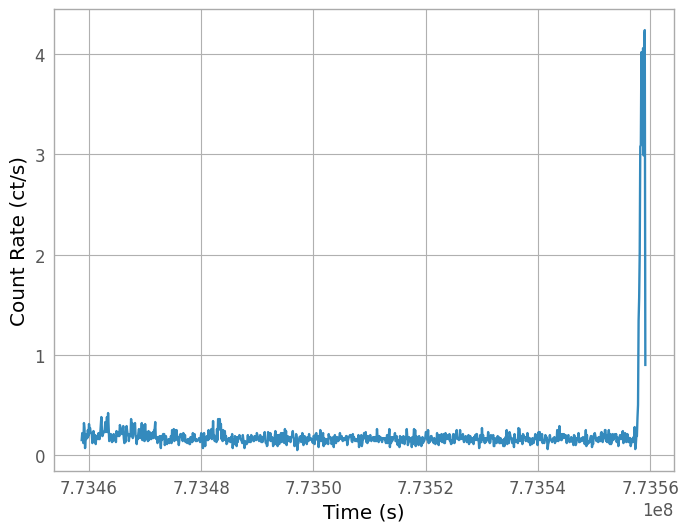

In [171]:
# now we extract a light curve from these bkg-only, energy and pattern filtered event files to judge tthe presence of flaring activity in the background
# these flaring periods can degrade the quality of our analyses, and we need to clip out periods of higher than average background activity. 

# first for pn
light_curve_file='pn_bkg_lightcurve.fits'
filtered_event_list = 'pn_filt_bkg_gtr10kev.fits'
# now plotting the light curve to the side
myobs.quick_lcplot(filtered_event_list,light_curve_file=light_curve_file)

# this quick_lcplot generates a light curve event file and supplies the following commands to evselect:
# inargs = {'table'          : event_list_file, 
#           'withrateset'    : 'yes', 
#           'rateset'        : light_curve_file, 
#           'maketimecolumn' : 'yes', 
#           'timecolumn'     : 'TIME', 
#           'timebinsize'    : '100', 
#           'makeratecolumn' : 'yes'}



# Note to talk to Ryan T:
# We should really change this to a scatterplot with error bars, rather than a line plot. Makes it a bit harder to read/interpret.

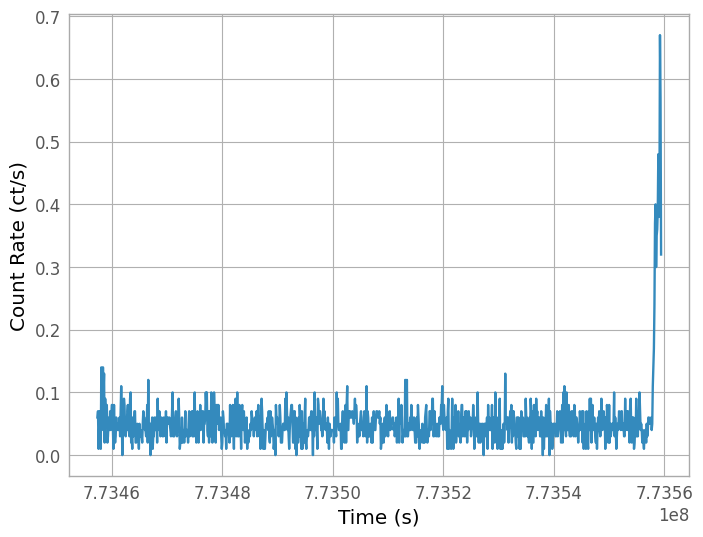

In [172]:
# now we check for mos1 
light_curve_file='mos1_bkg_lightcurve.fits'
filtered_event_list = 'mos1_filt_bkg_gtr10kev.fits'
# now plotting the light curve to the side
myobs.quick_lcplot(filtered_event_list,light_curve_file=light_curve_file)


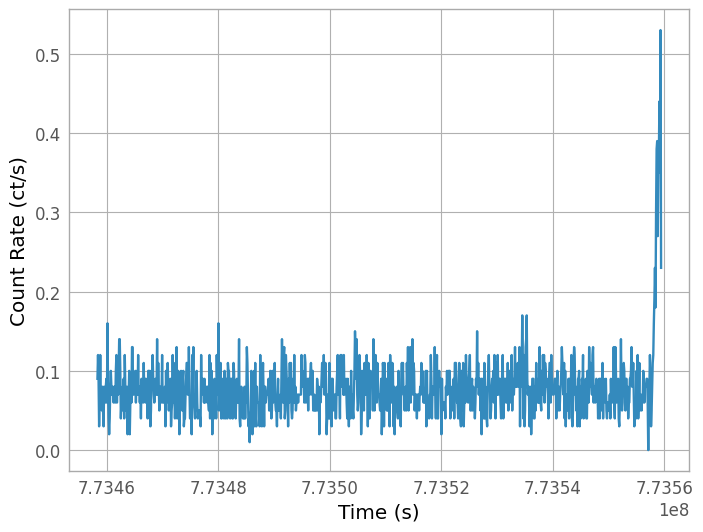

In [173]:
# and for mos2
light_curve_file='mos2_bkg_lightcurve.fits'
filtered_event_list = 'mos2_filt_bkg_gtr10kev.fits'
# now plotting the light curve to the side
myobs.quick_lcplot(filtered_event_list,light_curve_file=light_curve_file)


# a note to self: it would be really great if we could have it just plot all three in the same cell... I can try and see if it will work or not
# but realistically it would be great if I could just plot the three side by side with labels instead of vertically one after another...



### Notice how the light curves are actually different between the three cameras... and note, you can have different background light curves and average count rates across all three detectors, so it is best to run this exercise for pn, mos1, and mos2


In pn, we witnessed a huge background flare, and yet with mos1 and mos2, the light curves are quiescent. For mos1 and 2, we can go with a count rate cut off 0.15, which is above the observed quiescent background count rates...

We can see in the generated plot of the hard X-ray (10 keV < E < 12 keV) background light curve there is a large flare at the start of the observationbut the rest of the observation shows a stable background before removing sources, the count rate bounces around just below 0.2 cts/s

At the peak of the flaring episode, the count rate reached ~1.2 cts/s, nearly 8x the average count rate during the non-flaring period! 

The general rule of thumb for background light curve cleaning, as given in the ESA XMM-Newton SAS Guide (insert section number here), is <0.4 cts/s for pn, and <0.35 cts/s for mos1 and mos2. However, it is often better to choose a count rate cut off closer to the average rate during quiescent periods. For our current data set, a cut off of <0.4 cts/s would leave in a substantial period of background flaring. Every source and scientific analysis is different; in some cases, it may be useful to include such high background flaring periods if one needs more S/N. the more conservative approach would be to use a lower background count rate cut off that is closer to the average count rate observed in the background light curve observed during quiescent periods of time. So in our case, we will adopt a count rate cut off 0.15 cts/s.



--> Add descriptive text here about what this next cell is finally doing

In [174]:
# Applying that count rate now and generating a ``good time interval'' (GTI) file....

# ^^^^ Ryan, come back and change text/average count rate after removal of point sources (I suspect the AGN is constributing to the count rate)

# We will now apply the GTI file to our original events files

# allowing the user to input their choice of count rate cut off here
# pn
# pnrate = input()
#mos1
# mos1rate = input()
#mos2
# mos2rate = input()
# if r in [pnrate,mos1rate,mos2rate]: # trying to add in a lilttle loop here that if the user does not apply a filter it will 
#     if '' in r:                     # auto-choose the general rule of thumb values of 0.4 and 0.35 cts/s
        

# first we have to run tabgtigen to generate the GTI files for pn, mos1, and mos2
pn_gti_file = 'gti_pn.fits'
pn_lightcurve_file = 'pn_bkg_lightcurve.fits' # this is the event list
rate = '0.25'
inargs = {'table'      : pn_lightcurve_file, 
          'gtiset'     : pn_gti_file,
          'timecolumn' : 'TIME', 
          "expression" : "'(RATE <= '" + str(rate) + "')'"}


print("\n********=========== Running tabgtigen with a count rate <="+ str(rate) +" ==========********\n")
MyTask('tabgtigen', inargs).run()

# and now for the mos cameras...
mos_gti_files = ['gti_mos1.fits','gti_mos2.fits']
mos_lightcurve_files = ['mos1_bkg_lightcurve.fits','mos2_bkg_lightcurve.fits'] # this is the event list
rates = ['0.15','0.15']
for gti_file, lightcurve_file, rate in zip(mos_gti_files, mos_lightcurve_files, rates):
    inargs = {'table'      : lightcurve_file, 
              'gtiset'     : gti_file,
              'timecolumn' : 'TIME', 
              "expression" : "'(RATE <= '"+str(rate)+"')'"}
    print("\n********=========== Running tabgtigen with a count rate <=" + str(rate) + " ==========********\n")
    MyTask('tabgtigen', inargs).run()


# throwing a warning to the user to verify they used the count rate cut offs they intended to...
print("\n********=========== WARNING! ==========********")
print("\n VERIFY YOU ARE USING YOUR INTENDED COUNT RATE ")
print("\n********===============================********\n")




********=========== Running tabgtigen with a count rate <=0.25 ==========********

Executing: 
tabgtigen table='pn_bkg_lightcurve.fits' gtiset='gti_pn.fits' expression='(RATE <= 0.25)' timecolumn='TIME' prefraction='0.5' postfraction='0.5' mingtisize='0.0'
tabgtigen:- Executing (routine): tabgtigen table=pn_bkg_lightcurve.fits gtiset=gti_pn.fits expression='(RATE <= 0.25)' timecolumn=TIME prefraction=0.5 postfraction=0.5 mingtisize=0  -w 1 -V 2

********=========== Running tabgtigen with a count rate <=0.15 ==========********

tabgtigen executed successfully!
Executing: 
tabgtigen table='mos1_bkg_lightcurve.fits' gtiset='gti_mos1.fits' expression='(RATE <= 0.15)' timecolumn='TIME' prefraction='0.5' postfraction='0.5' mingtisize='0.0'
tabgtigen:- Executing (routine): tabgtigen table=mos1_bkg_lightcurve.fits gtiset=gti_mos1.fits expression='(RATE <= 0.15)' timecolumn=TIME prefraction=0.5 postfraction=0.5 mingtisize=0  -w 1 -V 2

********=========== Running tabgtigen with a count rate <=

# Stage 2.5. Final cleaning of the event files using the good time interval files

--> Add descriptive text of what we're doing here

In [175]:

# and now we will run evselect again and use our GTI file to remove periods of flaring
filtered_event_list = 'pn_filt.fits'
cleaned_evt_list = 'pn_cl.fits'
inargs = {'table'           : filtered_event_list,
          'withfilteredset' : 'yes', 
          "expression"      : "'GTI({0},TIME)'".format(pn_gti_file), 
          'filteredset'     : cleaned_evt_list,
          'filtertype'      : 'expression', 
          'keepfilteroutput': 'yes',
          'updateexposure'  : 'yes', 
          'filterexposure'  : 'yes'}

MyTask('evselect', inargs).run()


# and now for the mos cameras....
filtered_event_lists = ['mos1_filt.fits','mos2_filt.fits']
cleaned_evt_lists = ['mos1_cl.fits','mos2_cl.fits']
for filtered_event_list, cleaned_evt_list, gti_file in zip(filtered_event_lists, cleaned_evt_lists, mos_gti_files):
    inargs = {'table'           : filtered_event_list,
              'withfilteredset' : 'yes', 
              "expression"      : "'GTI({0},TIME)'".format(gti_file), 
              'filteredset'     : cleaned_evt_list,
              'filtertype'      : 'expression', 
              'keepfilteroutput': 'yes',
              'updateexposure'  : 'yes', 
              'filterexposure'  : 'yes'}
    
    MyTask('evselect', inargs).run()


print("\n********===============================********")
print("\n Now limiting our event lists based on our good-time-interval files (generated based on the count rates in our background light curves above) ")
print("\n********===============================********\n")



Executing: 
evselect table='pn_filt.fits' keepfilteroutput='yes' withfilteredset='yes' filteredset='pn_cl.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='GTI(gti_pn.fits,TIME)' writedss='no' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='no' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='11999' nonStandardSpec='no' withr

### We have now generated our cleaned event lists, which have been filtered on energy, patterns, bad pixels removed, and cleaned of any background flaring. Based on the commands above, these images are labeled `pn_cl.fits`, `mos1_cl.fits`, and `mos2_cl.fits`.

### For reference (as before), the above pySAS commands can be reproduced in SAS at command line via: 


`evselect table=${ARG1}a.fits withfilteredset=Y filteredset=${ARG1}a-cl1.fits expression="GTI(${ARG1}ti1.fits,TIME)" filtertype=expression keepfilteroutput=yes updateexposure=yes filterexposure=yes`


### We will now visualize the files one more time during the Stage 2 processing and inspect them:

In [176]:
# now visualizing these images to demonstrate what the cleaned images look like
make_fits_image('pn_cl.fits')
make_fits_image('mos1_cl.fits')
make_fits_image('mos2_cl.fits')

# these event files have now been cleaned of bad patterns, bad pixels, limited to the energy bands X keV for pn and \
# X keV for mos1 and mos2

Executing: 
evselect table='pn_cl.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='yes' imageset='image.fits' xcolumn='X' ycolumn='Y' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='11999' nonStandardSpec='no' withrateset='no' rateset='r

'image.fits'

# (Extra) Stage 2.6: Running one final dummy test to verify the event lists are free of background flaring

### This dummy test will involve repeating some of our previous commands, except now we will run them on the cleaned event file. In essence, we will repeat the following steps:

- Excluding of point sources from the cleaned event lists
- Limiting of cleaned event lists to energies to 10 keV <= E <= 12 keV for pn and 10 keV <= E <=15 keV for mos1 and mos2
- Using FLAG==0 for pn and FLAG==\#XMMEA_EM for mos1 and mos2
- Limiting the cleaned event files to PATTERN==0 for pn and PATTERN <=4 for mos1 and mos2



Executing: 
evselect table='pn_cl.fits' keepfilteroutput='yes' withfilteredset='yes' filteredset='pn_cl_bkg_gtr10kev.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='(PATTERN == 0)&&(PI in [10000:12000])&&FLAG==0 .and. .not. circle(9067.86,25804.43,220.0,X,Y) .and. .not. circle(9459.18,30750.68,360.0,X,Y) .and. .not. circle(9466.08,25511.9,300.0,X,Y) .and. .not. circle(9530.36,21830.98,320.0,X,Y) .and. .not. circle(10239.73,25328.36,400.0,X,Y) .and. .not. circle(10882.71,19040.85,360.0,X,Y) .and. .not. circle(11080.49,30188.63,700.0,X,Y) .and. .not. circle(11160.99,22870.48,280.0,X,Y) .and. .not. circle(11580.84,37915.14,400.0,X,Y) .and. .not. circle(11640.94,18296.86,340.0,X,Y) .and. .not. circle(11769.37,27886.84,320.0,X,Y) .and. .not. circle(11945.25,25484.95,300.0,X,Y) .and. .not. circle(12310.64,24116.7,320.0,X,Y) .and. .not. circle(12894.96,26066.46,380.0,X,Y) .and. .not. circle(12919.61,23001.62,240.0,X,Y) .and. .not. circle(1

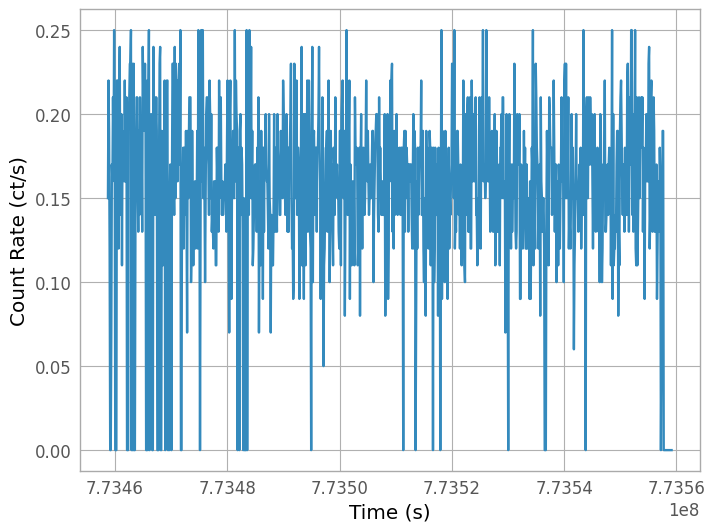

Executing: 
evselect table='mos1_cl.fits' keepfilteroutput='yes' withfilteredset='yes' filteredset='mos1_cl_bkg_gtr10kev.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='(PATTERN <= 4)&&(PI in [10000:15000])&&FLAG==#XMMEA_EM .and. .not. circle(9067.86,25804.43,220.0,X,Y) .and. .not. circle(9459.18,30750.68,360.0,X,Y) .and. .not. circle(9466.08,25511.9,300.0,X,Y) .and. .not. circle(9530.36,21830.98,320.0,X,Y) .and. .not. circle(10239.73,25328.36,400.0,X,Y) .and. .not. circle(10882.71,19040.85,360.0,X,Y) .and. .not. circle(11080.49,30188.63,700.0,X,Y) .and. .not. circle(11160.99,22870.48,280.0,X,Y) .and. .not. circle(11580.84,37915.14,400.0,X,Y) .and. .not. circle(11640.94,18296.86,340.0,X,Y) .and. .not. circle(11769.37,27886.84,320.0,X,Y) .and. .not. circle(11945.25,25484.95,300.0,X,Y) .and. .not. circle(12310.64,24116.7,320.0,X,Y) .and. .not. circle(12894.96,26066.46,380.0,X,Y) .and. .not. circle(12919.61,23001.62,240.0,X,Y) .and. .n

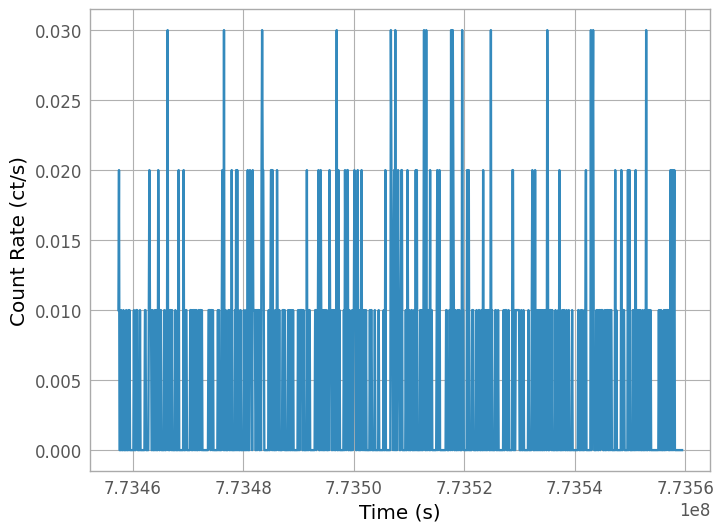

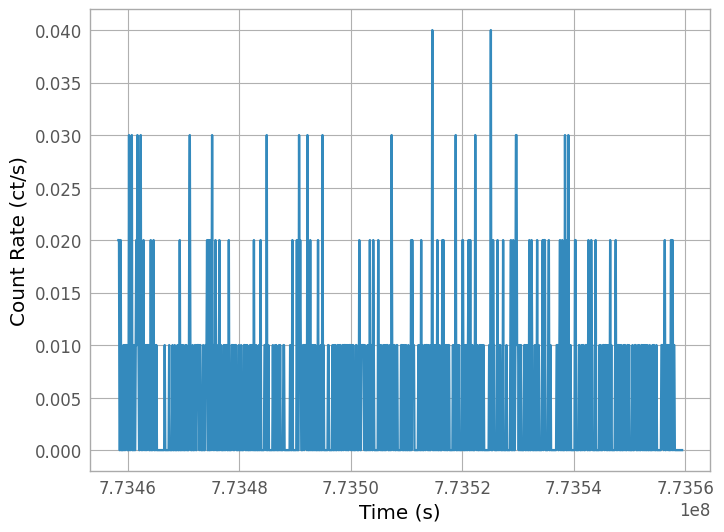

In [178]:
# now we'll run a fast check to make sure the event file is now cleaned!
filtered_event_list = 'pn_cl_bkg_gtr10kev.fits'
inputtable = 'pn_cl.fits'
inargs = {'table'           : inputtable, 
          'withfilteredset' : 'yes', 
          "expression"      : "'(PATTERN == 0)&&(PI in [10000:12000])&&FLAG==0'"+str(exclude), 
          'filteredset'     : filtered_event_list, 
          'filtertype'      : 'expression', 
          'keepfilteroutput': 'yes', 
          'updateexposure'  : 'yes', 
          'filterexposure'  : 'yes'}
# and then we run the evselect command using our dictionary of SAS input arguments to clean the event files
MyTask('evselect', inargs).run()


# and now generating the light curve from the "clean" bkg file
light_curve_file='pn_cl_bkg_lightcurve.fits'
filtered_event_list = 'pn_cl_bkg_gtr10kev.fits'
# now plotting the light curve to the side
myobs.quick_lcplot(filtered_event_list,light_curve_file=light_curve_file)



# and now again for the mos cameras.... (even though in this example, we saw there were no background flares in mos1 and 2, it's \
# still good practice to check your final light curve and make sure everything looks the way it should -- i.e. nice and stable.)

filtered_event_list = ['mos1_cl_bkg_gtr10kev.fits', 'mos2_cl_bkg_gtr10kev.fits']
evttables = ['mos1_cl.fits', 'mos2_cl.fits']
for i, j in zip(filtered_event_list,evttables):
    inargs = {'table'           : j, 
              'withfilteredset' : 'yes', 
              "expression"      : "'(PATTERN <= 4)&&(PI in [10000:15000])&&FLAG==#XMMEA_EM'"+str(exclude), 
              'filteredset'     : i, 
              'filtertype'      : 'expression', 
              'keepfilteroutput': 'yes', 
              'updateexposure'  : 'yes', 
              'filterexposure'  : 'yes'}
    # and then we run the evselect command using our dictionary of SAS input arguments to clean the event files
    MyTask('evselect', inargs).run()



# checking mos1 cleaned light curve now
light_curve_file='mos1_cl_bkg_lightcurve.fits'
filtered_event_list = 'mos1_cl_bkg_gtr10kev.fits'
# now plotting the light curve to the side
myobs.quick_lcplot(filtered_event_list,light_curve_file=light_curve_file)


# checking mos2 cleaned light curve now and now generating the light curve from the "clean" bkg file
light_curve_file='mos2_cl_bkg_lightcurve.fits'
filtered_event_list = 'mos2_cl_bkg_gtr10kev.fits'
# now plotting the light curve to the side
myobs.quick_lcplot(filtered_event_list,light_curve_file=light_curve_file)

#make_fits_image('pn_cl_bkg_gtr10kev.fits')

#print("\nPlease inspect the the *cleaned* ${ARG1} background light curve found in lc_${ARG1}_bkgm1-10_clean.ps.\n")
#print("Ensure there are no background flaring events. Opening file now...\n\n")



#### And we see that in each case, our light curves are cleaned of any background particle flaring. And with this final check, our data are now cleaned and ready for further use! As long as the data are not piled up, we are now ready to proceed with science product generation, starting with science images and exposure maps, before moving on to spectral extraction below....

### For reference, these commands are equivalent to the following SAS commands that can be entered in SAS at command line:

<div style='color: #333; background: #ffffdf; padding:20px; border: 4px solid #fadbac'>

\# Running evselect to limit the energies again, as well as using basic bash commands to put together an input expression for excluding the point source regions

`sources=".not. "$(cat ${ARG1}-srcs.reg | awk '{gsub(/\)/, ",X,Y)", $1); print}' ORS=' .and. .not. ')`

`source=${sources%?????????????} # Remove the last 13 characters (there's an additional ' .and. .not. ' that we do not need.)`

`energies=" PI.ge.2000 .and. PI.le.12000 .and. "`

`source=${energies}${source}`

`evselect table=${ARG1}a-cl1.fits withfilteredset=yes keepfilteroutput=yes filtertype=expression updateexposure=yes filterexposure=yes expression="$source" filteredset=${ARG1}abkg_clean.fits`


\# Using evselect to generate a light curve file

`evselect table=${ARG1}abkg_clean.fits withrateset=yes rateset=lc_${ARG1}_bkgm1-10_clean.fits maketimecolumn=yes timecolumn=TIME timebinsize=100 makeratecolumn=yes expression=" PI.gt.10000 .and. (PATTERN==0) " `

\# lcurve is a heasaoft tool used to plot the light curve file

`lcurve nser=1 cfile1=lc_${ARG1}_bkgm1-10_clean.fits dtnb=100 nbint=5000 window="-" outfile=lc_${ARG1}_bkgm1-10_clean plot=yes plotdev="/xw" plotfile="${ARG1}_plt_commands_clean.pco"`

\# Note, you will need to use a command .pco file to format the light curve
</div>


### And with that, Stage 2 processing is complete! 

### At this point for most observations and sources the reprocessing steps are complete, and we can proceed with generating our science products. Other checks, such as checking for pile-up, will be dealt with during the science product generation, as this relies upon checking the spectroscopic and photometric properties of the source(s) in question. 


#--> Add this work to the board. Add in progress while working on it. 

# Stage 3: Science Data Product Generation

We will now generate useful scientific imaging and spectroscopic data products often used in scientific analyses, as well as demonstrate how to perform additional tasks like regnerating the XMM SAS source list, accounting for pile-up, etc. 

- 3.1: Generation of attitude file, energy filtered pn, mos1, and mos2 science images, and pn, mos1, and mos2 exposure maps
- 3.2: Assignment of source and background regions for spectral extraction
- 3.3: Spectroscopic extraction and response file generation
- 3.4: Basic visualization of extracted spectroscopic data products

In [179]:
# and we will now generate science products from these event lists, beginning first with science images generated from the event lists

# generating an attitude file, which will be useful later
# atthkgen atthkset=attitude.fits
MyTask('atthkgen', inargs={'atthkset' : 'attitude.fits'}).run()

# generating the full band 0.3-10 keV science images for pn, mos1, and mos2 and associated exposure maps
science_image = 'pn_0p3-10.fits'
inputtable = 'pn_cl.fits' 
inargs = {'table'           : inputtable, 
          'withimageset'    : 'yes',
          'imageset'        : science_image,
          'xcolumn'         : 'X',
          'ximagebinsize'   : '82',
          'ycolumn'         : 'Y',
          'yimagebinsize'   : '82',
          'filtertype'      : 'expression',
          'expression'      : '(PI in [300:10000])'}
#'imagebinning'    : 'binSize',
MyTask('evselect', inargs).run()

# and now the pn exposure map
inargs = {'imageset'        : science_image,
          'attitudeset'     : 'attitude.fits',
          'eventset'        : inputtable,
          'expimageset'     : str(inputtable[0:2:1])+'_expmap_0p3-10.fits',
          'pimin'           : 300,
          'pimax'           : 10000}
MyTask('eexpmap', inargs).run()

# now mos1 and mos2 exp map
for science_image, inputtable in zip(['mos1_0p3-10.fits','mos2_0p3-10.fits'],['mos1_cl.fits','mos2_cl.fits']):
    # first the mos1 and mos2 science images
    inargs = {'table'           : inputtable, 
              'withimageset'    : 'yes',
              'imageset'        : science_image,
              'xcolumn'         : 'X',
              'ximagebinsize'   : '22',
              'ycolumn'         : 'Y',
              'yimagebinsize'   : '22',
              'filtertype'      : 'expression',
              'expression'      : '(PI in [300:10000])'}
    MyTask('evselect', inargs).run()
    # and now the mos1 and mos2 exposure maps
    inargs = {'imageset'        : science_image,
              'attitudeset'     : 'attitude.fits',
              'eventset'        : inputtable,
              'expimageset'     : str(inputtable[0:4:1])+'_expmap_0p3-10.fits',
              'pimin'           : 300,
              'pimax'           : 10000}
    MyTask('eexpmap', inargs).run()



# generating the full band 0.3-2 keV science images for pn, mos1, and mos2 and associated exposure maps

science_image = 'pn_0p3-2.fits'
inputtable = 'pn_cl.fits' 
inargs = {'table'           : inputtable, 
          'withimageset'    : 'yes',
          'imageset'        : science_image,
          'xcolumn'         : 'X',
          'ximagebinsize'   : '82',
          'ycolumn'         : 'Y',
          'yimagebinsize'   : '82',
          'filtertype'      : 'expression',
          'expression'      : '(PI in [300:2000])'}
#'imagebinning'    : 'binSize',
MyTask('evselect', inargs).run()

# and now the pn exposure map
inargs = {'imageset'        : science_image,
          'attitudeset'     : 'attitude.fits',
          'eventset'        : inputtable,
          'expimageset'     : str(inputtable[0:2:1])+'_expmap_0p3-2.fits',
          'pimin'           : 300,
          'pimax'           : 2000}
MyTask('eexpmap', inargs).run()

# now mos1 and mos2 exp map
for science_image, inputtable in zip(['mos1_0p3-2.fits','mos2_0p3-2.fits'],['mos1_cl.fits','mos2_cl.fits']):
    # first the mos1 and mos2 science images
    inargs = {'table'           : inputtable, 
              'withimageset'    : 'yes',
              'imageset'        : science_image,
              'xcolumn'         : 'X',
              'ximagebinsize'   : '22',
              'ycolumn'         : 'Y',
              'yimagebinsize'   : '22',
              'filtertype'      : 'expression',
              'expression'      : '(PI in [300:2000])'}
    MyTask('evselect', inargs).run()
    # and now the mos1 and mos2 exposure maps
    inargs = {'imageset'        : science_image,
              'attitudeset'     : 'attitude.fits',
              'eventset'        : inputtable,
              'expimageset'     : str(inputtable[0:4:1])+'_expmap_0p3-2.fits',
              'pimin'           : 300,
              'pimax'           : 2000}
    MyTask('eexpmap', inargs).run()



# generating the full band 2-10 keV science images for pn, mos1, and mos2 and associated exposure maps

science_image = 'pn_2-10.fits'
inputtable = 'pn_cl.fits' 
inargs = {'table'           : inputtable, 
          'withimageset'    : 'yes',
          'imageset'        : science_image,
          'xcolumn'         : 'X',
          'ximagebinsize'   : '82',
          'ycolumn'         : 'Y',
          'yimagebinsize'   : '82',
          'filtertype'      : 'expression',
          'expression'      : '(PI in [2000:10000])'}
MyTask('evselect', inargs).run()

# and now the pn exposure map
inargs = {'imageset'        : science_image,
          'attitudeset'     : 'attitude.fits',
          'eventset'        : inputtable,
          'expimageset'     : str(inputtable[0:2:1])+'_expmap_2-10.fits',
          'pimin'           : 2000,
          'pimax'           : 10000}
MyTask('eexpmap', inargs).run()

# now mos1 and mos2 exp map
for science_image, inputtable in zip(['mos1_2-10.fits','mos2_2-10.fits'],['mos1_cl.fits','mos2_cl.fits']):
    # first the mos1 and mos2 science images
    inargs = {'table'           : inputtable, 
              'withimageset'    : 'yes',
              'imageset'        : science_image,
              'xcolumn'         : 'X',
              'ximagebinsize'   : '22',
              'ycolumn'         : 'Y',
              'yimagebinsize'   : '22',
              'filtertype'      : 'expression',
              'expression'      : '(PI in [2000:10000])'}
    MyTask('evselect', inargs).run()
    # and now the mos1 and mos2 exposure maps
    inargs = {'imageset'        : science_image,
              'attitudeset'     : 'attitude.fits',
              'eventset'        : inputtable,
              'expimageset'     : str(inputtable[0:4:1])+'_expmap_2-10.fits',
              'pimin'           : 2000,
              'pimax'           : 10000}
    MyTask('eexpmap', inargs).run()


# note that you can also supply a list of energy ranges like below to automatically generate a series of energy filtered imaging

band = ['0p3-10','0p3-2','2-10']
lowE = [300, 300, 2000]
highE = [10000, 2000, 10000]



# Note: this step may take some time, as the correct calibration files are not always downloaded in the \
# local CCF directory, requiring SAS to query the ESA server for the relevant calibration files



Executing: 
atthkgen atthkset='attitude.fits' timestep='1' withtimeranges='no' timebegin='0' timeend='0' withpreqgti='no' preqgtifile='pointings.fit'
atthkgen:- Executing (routine): atthkgen atthkset=attitude.fits timestep=1 timebegin=0 timeend=0 withtimeranges=no withpreqgti=no preqgtifile=pointings.fit  -w 1 -V 2
atthkgen executed successfully!
pysas.sastask - WARNING  - No need to include imagebinning. Assumed imagebinning=binSize
Executing: 
evselect table='pn_cl.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='(PI in [300:10000])' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='yes' imageset='pn_0p3-10.fits' xcolumn='X' ycolumn='Y' imagebinning='binSize' ximagebinsize=

# At this point, we have now generated science images for the observation of NGC 4945. Congratulations, you now have science-ready data products!

# Now, suppose you were interested in searching for transient phenomena in NGC 4945. One quick and easy thing we could do is compare the previous observation of NGC 4945 (from 2004) to the latest obervation (from 2022). We will first compare them visually, and then we will compare the detected sources in their PPS region files.

# Let's begin by visualizing the images like so...

In [76]:

fs = s3fs.S3FileSystem(anon=True)



DEPRECATION: Loading egg at /home/idies/miniforge3/envs/xmmsas/lib/python3.11/site-packages/SciServer-2.1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/idies/miniforge3/envs/xmmsas/lib/python3.11/site-packages/SciServer-2.1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


DEPRECATION: Loading egg at /home/idies/miniforge3/envs/xmmsas/lib/python3.11/site-packages/SciServer-2.1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/idies/miniforge3/envs/xmmsas/lib/python3.11/site-packages/SciServer-2.1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


Set MJD-END to 53014.807292 from DATE-END'. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -1.200e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.332e+01 [aplpy.core]


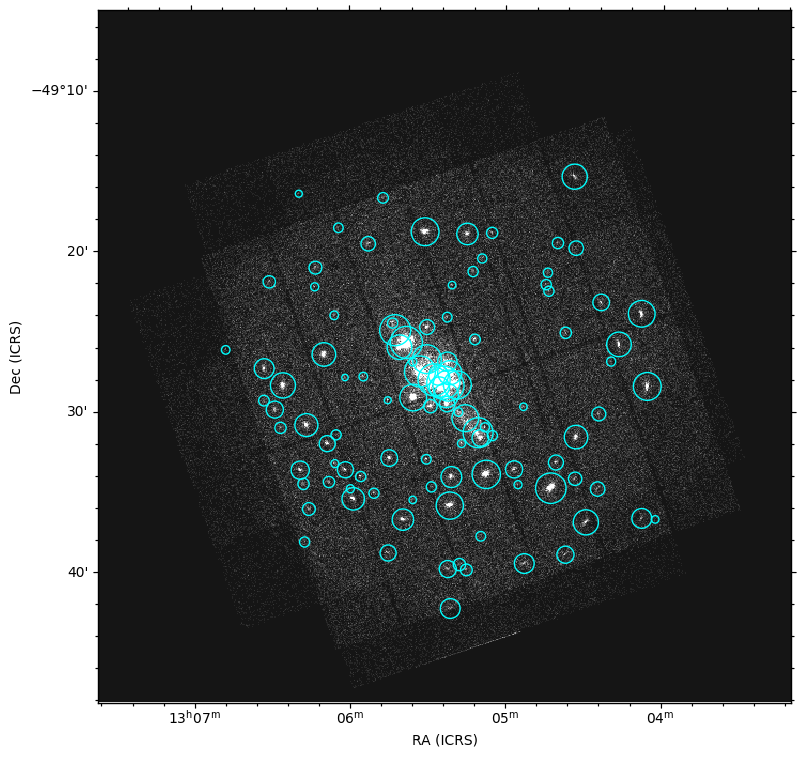

In [2]:
# We just downloaded and reprocessed the 2022 observation, but if we just want a quick look at the previous observation, we can simply stream the generated
# science exposure image via astropy.fits.io and plot that alongside our newly cleaned observation


# commands go here for finding and streaming the last observation using astroquery (and later we'll change to pyVO)
link="s3://nasa-heasarc/xmm/data/rev0/0204870101/"

#s3_uri = f"{links['aws'][0]}PPS/P0204870101EPX000OIMAGE8000.FTZ"
# where we have appended the file name "PPS" to the path (this is the directory housing the "*IMAGE8000.FTZ" file) as well as the wildcard argument needed to 
# grab the file we're interested in

# now we will use astropy.fits.io's open() function to stream our image file here
# and we will plot this with the convenient fits file/image plotting module `aplpy` which was pip installed above

s3_uri = f"{link}PPS/P0204870101EPX000OIMAGE8000.FTZ"
with fits.open(s3_uri, fsspec_kwargs={"anon": True}) as hdul:
    print(hdul)
    gc = aplpy.FITSFigure(hdul[0])
    gc.show_grayscale()
    hdul.close()
    s3_uri = f"{link}PPS/P0204870101EPX000REGION0000.ASC"
    with fs.open(s3_uri, 'rb') as file:
        lines = file.readlines()
        regs = []
        for line in lines[2::1]: # we're skipping the first couple of lines because they are just DS9 specific commands
            line = (line[11:35:1]).decode('utf-8') # we have to decode the lines because they are being read in as bytes
            ra, dec, rad = line.split(",")
            #print(ra,dec,rad)
            # add commands here to plot regions
            gc.show_circles(float(ra), float(dec), radius=int(rad)/3600, color='cyan') # note: radius is given in units of degrees
            # this will take about 40s to plot everything because we're plotting one at a time



In [180]:
make_fits_image('pn_cl.fits')


Executing: 
evselect table='pn_cl.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='true' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PHA' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='yes' imageset='image.fits' xcolumn='X' ycolumn='Y' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='no' spectrumset='spectrum.fits' spectralbinsize='5' withspecranges='no' specchannelmin='0' specchannelmax='11999' nonStandardSpec='no' withrateset='no' rateset='r

'image.fits'

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 59766.067303 from DATE-OBS.
Set MJD-END to 59767.230104 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 59766.067303 from DATE-OBS.
Set MJD-END to 59767.230104 from DATE-END'.
Set MJD-END to 53014.807292 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53014.807292 from DATE-END'.


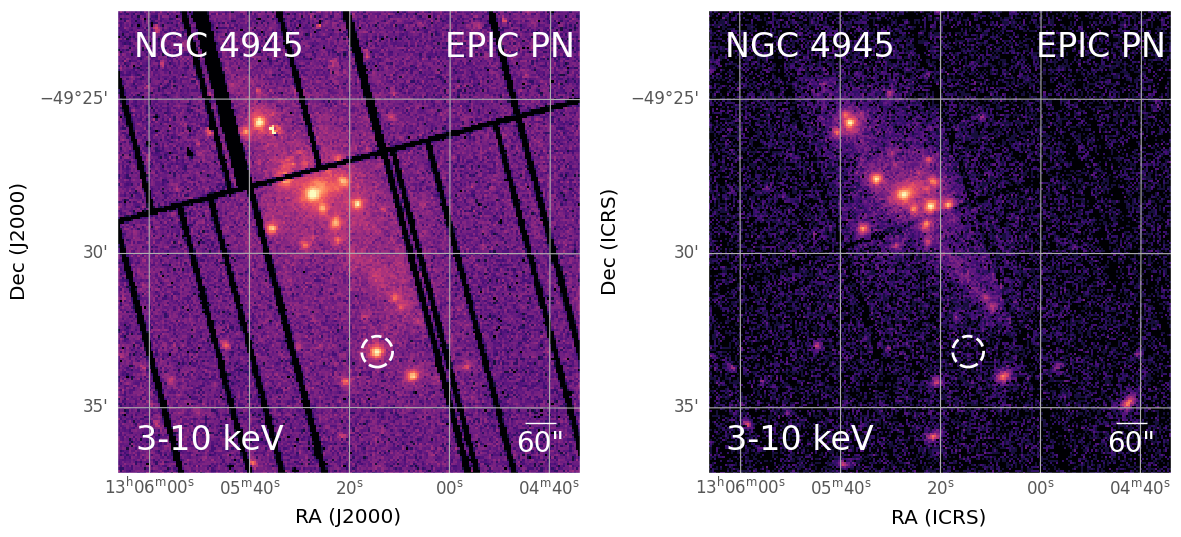

In [100]:
# here we're going to plot the 2022 observation alongside the PPS generated image of the 2004 observation to compare the
# the two


# this cell could be split in two to show the user use of s3fs and streaming, but hide the rest of the cell
fig = plt.figure(figsize=(12,6))

f1 = aplpy.FITSFigure('image.fits', downsample=False, figure = fig, subplot=(1,2,1)) #subplot=[0.25,y,0.25,0.25]

#for i, j in zip(wise['ra'], wise['dec']):
#    f1.show_circles(float(i), float(j), radius=10/3600, color='cyan') # note: radius is given in units of degrees
#    # this will take about 40s to plot everything because we're plotting one at a time

s3_uri = f"{link}PPS/P0204870101EPX000OIMAGE8000.FTZ"
with fits.open(s3_uri, fsspec_kwargs={"anon": True}) as hdul:
    f2 = aplpy.FITSFigure(hdul[0], downsample=False, figure = fig, subplot=(1,2,2))
    hdul.close()
    
for ax in [f1, f2]:
    # assigning color maps and scales uniformly
    ax.show_colorscale(vmin=1, vmax=500, cmap='magma', stretch='log') #smooth=3, kernel='gauss', 
    #recentering and resizing the image
    ax.recenter(196.3345024, -49.4934011, width=15/60, height=15/60)
    # adding scalebar
    ax.add_scalebar(60/3600.)
    ax.scalebar.set_label('%s"' % scl)
    ax.scalebar.set_color('white')
    ax.scalebar.set_font_size(20)
    # making the subplots a bit nicer here
    ax.frame.set_color('white')
    ax.add_label(0.22, 0.92, 'NGC 4945', relative=True, size=24, color='white')
    ax.add_label(0.2, 0.07, '3-10 keV', relative=True, size=24, color='white')
    ax.add_label(0.85, 0.92, 'EPIC PN', relative=True, size=24, color='white')
    # Add in the circle for our source on boht images
    ax.show_circles(196.3103384,-49.5530939, (30/(60*60)), color='white', linestyle='--', linewidth=2)

fig.canvas.draw()
plt.tight_layout()
#plt.savefig('Comparing_2022_to_2004.png', dpi=150) # commented this out for now
plt.show()

# this will take about 15-20s



In [ ]:
# here we're going to pull the source lists over for each and overlay them now on the images


# We've plotted sources detected in 2004 with red 15'' radius circles, while sources detected in 2022 with blue 30'' radius circles.

# Notice anything?

# There is a bright source in the 2022 observation about an arc minute and a half southeast of the nucleus of NGC 4945 that is not seen in the 2004 image

# Is this a new transient? Let's run a few quick tests to make sure we can rule out that it was simply below the detection limit of the 2004 observation

# --> We need to run edetectchain and get a source list made for the latest obs.
# I will provide that to the user, but also provide the commands for them to run it 
# and then we will have it load in their new file unless they don't run the command. In which
# case we will run with mine. 


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 59766.067303 from DATE-OBS.
Set MJD-END to 59767.230104 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 59766.067303 from DATE-OBS.
Set MJD-END to 59767.230104 from DATE-END'.
Set MJD-END to 53014.807292 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 53014.807292 from DATE-END'.


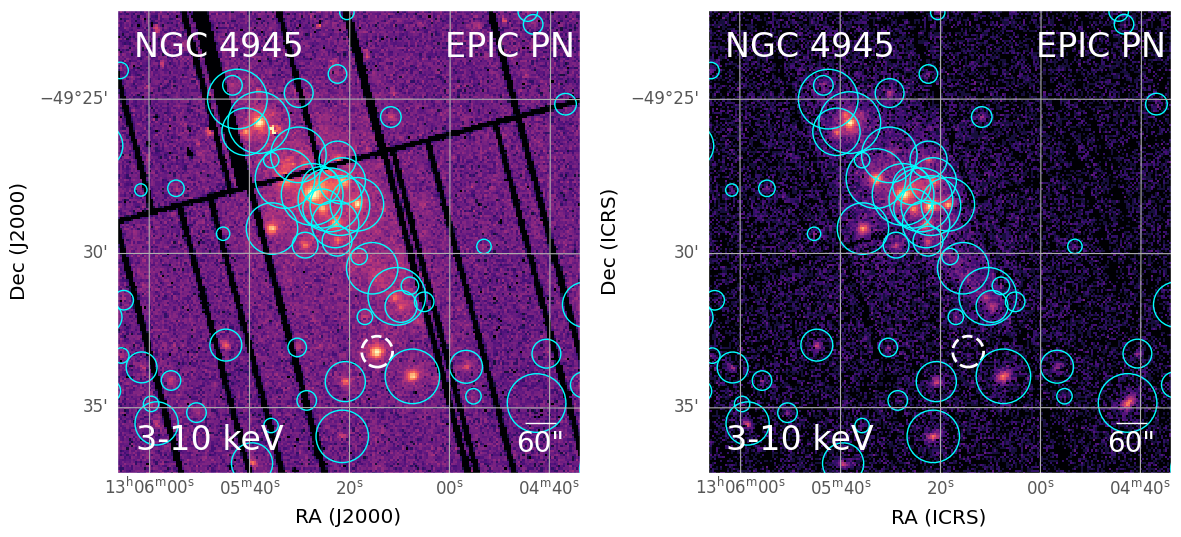

In [101]:
# Okay, we can see now that the source we found in 2022 does not appear to be in the 2004 image
# --> note, ryan, you can always add in the 2001 image too

# Are we sure we did not see the source in 2004? Let's overlay the 2004 regions on top of both of these images to make sure

# here we're going to plot the 2022 observation alongside the PPS generated image of the 2004 observation to compare the
# the two

fig = plt.figure(figsize=(12,6))

f1 = aplpy.FITSFigure('image.fits', downsample=False, figure = fig, subplot=(1,2,1)) #subplot=[0.25,y,0.25,0.25]

#for i, j in zip(wise['ra'], wise['dec']):
#    f1.show_circles(float(i), float(j), radius=10/3600, color='cyan') # note: radius is given in units of degrees
#    # this will take about 40s to plot everything because we're plotting one at a time

s3_uri = f"{link}PPS/P0204870101EPX000OIMAGE8000.FTZ"
with fits.open(s3_uri, fsspec_kwargs={"anon": True}) as hdul:
    f2 = aplpy.FITSFigure(hdul[0], downsample=False, figure = fig, subplot=(1,2,2))
    hdul.close()
    
for ax in [f1, f2]:
    # assigning color maps and scales uniformly
    ax.show_colorscale(vmin=1, vmax=500, cmap='magma', stretch='log') #smooth=3, kernel='gauss', 
    #recentering and resizing the image
    ax.recenter(196.3345024, -49.4934011, width=15/60, height=15/60)
    # adding scalebar
    ax.add_scalebar(60/3600.)
    ax.scalebar.set_label('%s"' % scl)
    ax.scalebar.set_color('white')
    ax.scalebar.set_font_size(20)
    # making the subplots a bit nicer here
    ax.frame.set_color('white')
    ax.add_label(0.22, 0.92, 'NGC 4945', relative=True, size=24, color='white')
    ax.add_label(0.2, 0.07, '3-10 keV', relative=True, size=24, color='white')
    ax.add_label(0.85, 0.92, 'EPIC PN', relative=True, size=24, color='white')
    # Add in the circle for our source on boht images
    ax.show_circles(196.3103384,-49.5530939, (30/(60*60)), color='white', linestyle='--', linewidth=2)

    s3_uri = f"{link}PPS/P0204870101EPX000REGION0000.ASC"
    with fs.open(s3_uri, 'rb') as file:
        lines = file.readlines()
        regs = []
        for line in lines[2::1]: # we're skipping the first couple of lines because they are just DS9 specific commands
            line = (line[11:35:1]).decode('utf-8') # we have to decode the lines because they are being read in as bytes
            ra, dec, rad = line.split(",")
            #print(ra,dec,rad)
            # add commands here to plot regions
            ax.show_circles(float(ra), float(dec), radius=int(rad)/3600, color='cyan') # note: radius is given in units of degrees
            # this will take about 40s to plot everything because we're plotting one at a time

fig.canvas.draw()
plt.tight_layout()
#plt.savefig('Comparing_2022_to_2004.png', dpi=150) # commented this out for now
plt.show()

# this will take about 15-20s



In [ ]:
# So we know this was detected in 2022 and not in 2004. What about the 2001 observation? If we repeated this exercise, we will find the source was also not 
# active in 2001. So is this the first time we've seen this source? Certainly with XMM that is true. Let's check out a few other places. 

# Let's first check the Chandra point source catalog, which includes all sources detected across the various NGC 4945 observations, and then we will also check
# a stacked Chandra image 


# So nothing in Chandra over the years. What else can we try? 

# Swift! Swift has operated as a rapid time domain mission for many years now, and there are a large number of observations of NGC 4945. 

# Note, there are a number of Swift specific tools that we could use outside of this notebook, as we describe here:


# If we run 

In [103]:
# Now we will begin looking for a counterpart in the IRSA catalogs. We'll start off checking the WISE all-sky point source
# catalog

#Irsa.list_catalogs(filter='wise')

position = SkyCoord(196.3103384, -49.5530939, frame='icrs', unit="deg")

# we're going to use a 30'' match tolerance to get a sense for what the field looks like in terms of mid-IR sources nearby
wise = Irsa.query_region(coordinates=position, spatial='Cone', catalog='allwise_p3as_psd', radius=1.0*u.arcmin)
wise = wise[(wise['w1snr']>=3) & (wise['w2snr']>=3)] # taking only high quality detections

In [104]:
wise

designation,ra,dec,sigra,sigdec,sigradec,glon,glat,elon,elat,wx,wy,cntr,source_id,coadd_id,src,w1mpro,w1sigmpro,w1snr,w1rchi2,w2mpro,w2sigmpro,w2snr,w2rchi2,w3mpro,w3sigmpro,w3snr,w3rchi2,w4mpro,w4sigmpro,w4snr,w4rchi2,rchi2,nb,na,w1sat,w2sat,w3sat,w4sat,satnum,ra_pm,dec_pm,sigra_pm,sigdec_pm,sigradec_pm,pmra,sigpmra,pmdec,sigpmdec,w1rchi2_pm,w2rchi2_pm,w3rchi2_pm,w4rchi2_pm,rchi2_pm,pmcode,cc_flags,rel,ext_flg,var_flg,ph_qual,det_bit,moon_lev,w1nm,w1m,w2nm,w2m,w3nm,w3m,w4nm,w4m,w1cov,w2cov,w3cov,w4cov,w1cc_map,w1cc_map_str,w2cc_map,w2cc_map_str,w3cc_map,w3cc_map_str,w4cc_map,w4cc_map_str,best_use_cntr,ngrp,w1flux,w1sigflux,w1sky,w1sigsk,w1conf,w2flux,w2sigflux,w2sky,w2sigsk,w2conf,w3flux,w3sigflux,w3sky,w3sigsk,w3conf,w4flux,w4sigflux,w4sky,w4sigsk,w4conf,w1mag,w1sigm,w1flg,w1mcor,w2mag,w2sigm,w2flg,w2mcor,w3mag,w3sigm,w3flg,w3mcor,w4mag,w4sigm,w4flg,w4mcor,w1mag_1,w1sigm_1,w1flg_1,w2mag_1,w2sigm_1,w2flg_1,w3mag_1,w3sigm_1,w3flg_1,w4mag_1,w4sigm_1,w4flg_1,w1mag_2,w1sigm_2,w1flg_2,w2mag_2,w2sigm_2,w2flg_2,w3mag_2,w3sigm_2,w3flg_2,w4mag_2,w4sigm_2,w4flg_2,w1mag_3,w1sigm_3,w1flg_3,w2mag_3,w2sigm_3,w2flg_3,w3mag_3,w3sigm_3,w3flg_3,w4mag_3,w4sigm_3,w4flg_3,w1mag_4,w1sigm_4,w1flg_4,w2mag_4,w2sigm_4,w2flg_4,w3mag_4,w3sigm_4,w3flg_4,w4mag_4,w4sigm_4,w4flg_4,w1mag_5,w1sigm_5,w1flg_5,w2mag_5,w2sigm_5,w2flg_5,w3mag_5,w3sigm_5,w3flg_5,w4mag_5,w4sigm_5,w4flg_5,w1mag_6,w1sigm_6,w1flg_6,w2mag_6,w2sigm_6,w2flg_6,w3mag_6,w3sigm_6,w3flg_6,w4mag_6,w4sigm_6,w4flg_6,w1mag_7,w1sigm_7,w1flg_7,w2mag_7,w2sigm_7,w2flg_7,w3mag_7,w3sigm_7,w3flg_7,w4mag_7,w4sigm_7,w4flg_7,w1mag_8,w1sigm_8,w1flg_8,w2mag_8,w2sigm_8,w2flg_8,w3mag_8,w3sigm_8,w3flg_8,w4mag_8,w4sigm_8,w4flg_8,w1magp,w1sigp1,w1sigp2,w1k,w1ndf,w1mlq,w1mjdmin,w1mjdmax,w1mjdmean,w2magp,w2sigp1,w2sigp2,w2k,w2ndf,w2mlq,w2mjdmin,w2mjdmax,w2mjdmean,w3magp,w3sigp1,w3sigp2,w3k,w3ndf,w3mlq,w3mjdmin,w3mjdmax,w3mjdmean,w4magp,w4sigp1,w4sigp2,w4k,w4ndf,w4mlq,w4mjdmin,w4mjdmax,w4mjdmean,rho12,rho23,rho34,q12,q23,q34,xscprox,w1rsemi,w1ba,w1pa,w1gmag,w1gerr,w1gflg,w2rsemi,w2ba,w2pa,w2gmag,w2gerr,w2gflg,w3rsemi,w3ba,w3pa,w3gmag,w3gerr,w3gflg,w4rsemi,w4ba,w4pa,w4gmag,w4gerr,w4gflg,tmass_key,r_2mass,pa_2mass,n_2mass,j_m_2mass,j_msig_2mass,h_m_2mass,h_msig_2mass,k_m_2mass,k_msig_2mass,x,y,z,spt_ind,htm20
,deg,deg,arcsec,arcsec,arcsec,deg,deg,deg,deg,pix,pix,,,,,mag,mag,,,mag,mag,,,mag,mag,,,mag,mag,,,,,,,,,,,deg,deg,arcsec,arcsec,arcsec,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,count,mag,mag,,mag,mag,mag,,mag,mag,mag,,mag,mag,mag,,mag,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,mag,,,,,,,mag,mag,mag,,,,,,,mag,mag,mag,,,,,,,mag,mag,mag,,,,,,,,,,,,,arcsec,arcsec,,deg,mag,mag,,arcsec,,deg,mag,mag,,arcsec,,deg,mag,mag,,arcsec,,deg,mag,mag,,,arcsec,deg,,mag,mag,mag,mag,mag,mag,,,,,
object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,object,int64,float32,float32,float64,float32,float32,float32,float64,float32,float32,float32,float64,float32,float32,float32,float64,float32,float32,int64,int64,float32,float32,float32,float32,object,float64,float64,float64,float64,float64,int64,int64,int64,int64,float32,float32,float32,float32,float32,object,object,object,int64,object,object,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,float32,float32,float32,float32,int64,object,int64,object,int64,object,int64,object,int64,int32,float32,float32,float64,float32,float64,float32,float32,float64,float32,float64,float32,float32,float64,float32,float64,float32,float32,float64,float32,float64,float32,float32,int64,float32,float32,float32,int64,float32,float32,float32,int64,float32,float3

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 59766.067303 from DATE-OBS.
Set MJD-END to 59767.230104 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 59766.067303 from DATE-OBS.
Set MJD-END to 59767.230104 from DATE-END'.


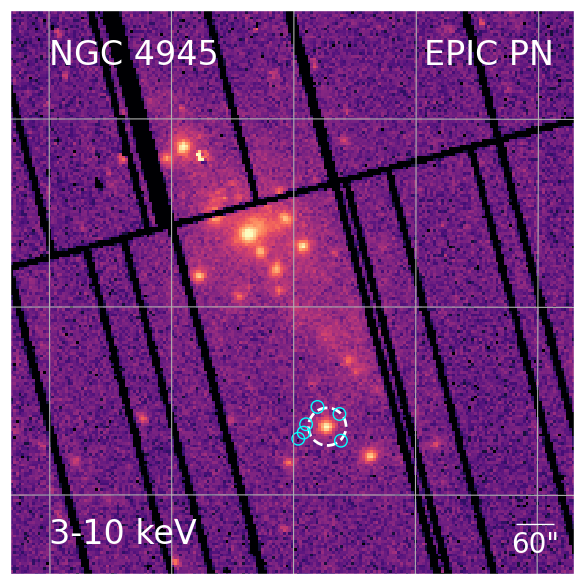

In [105]:
fig = plt.figure(figsize=(6,6))

f1 = aplpy.FITSFigure('image.fits', downsample=False, figure = fig) #subplot=[0.25,y,0.25,0.25]
f1.show_colorscale(vmin=1, vmax=500, cmap='magma', stretch='log') #smooth=3, kernel='gauss', 
f1.recenter(196.3345024, -49.4934011, width=15/60, height=15/60)

# Add in the circle for our source
f1.show_circles(196.3103384,-49.5530939, (30/(60*60)), color='white', linestyle='--', linewidth=2)

for i, j in zip(wise['ra'], wise['dec']):
    f1.show_circles(float(i), float(j), radius=10/3600, color='cyan') # note: radius is given in units of degrees
    # this will take about 40s to plot everything because we're plotting one at a time

f1.add_scalebar(60/3600.)
f1.scalebar.set_label('%s"' % scl)
f1.scalebar.set_color('white')
f1.scalebar.set_font_size(20)
f1.ticks.hide()
f1.tick_labels.hide()
f1.axis_labels.hide()
f1.frame.set_color('white')
f1.add_label(0.22, 0.92, 'NGC 4945', relative=True, size=24, color='white')
f1.add_label(0.2, 0.07, '3-10 keV', relative=True, size=24, color='white')
f1.add_label(0.85, 0.92, 'EPIC PN', relative=True, size=24, color='white')


plt.tight_layout()
plt.show()


# so there are sources within 1 armin but none within 30''
# WISE has an astrometric precision of <0.5'', and we know that the
# uncertainty on the astrometric precision for our detected source is <2''. So while
# these sources are nearby, they must be associated with other sources/phenomenon.

# next we will check the neo-wise light curves and see if we can spot any variability


# --> and then we will also plot that on the image so we can visualize the position

In [197]:
Irsa.list_catalogs(filter='ztf')

{'ztf_objects_dr23': 'ZTF DR23 Objects',
 'ztf_objects_dr22': 'ZTF DR22 Objects',
 'ztf_objects_dr21': 'ZTF DR21 Objects',
 'ztf_objects_dr20': 'ZTF DR20 Objects',
 'ztf_objects_dr19': 'ZTF DR19 Objects',
 'ztf.ztf_current_meta_sci': 'ZTF Science Exposure Images',
 'ztf.ztf_current_meta_ref': 'ZTF Reference (coadd) Images',
 'ztf.ztf_current_meta_raw': 'ZTF Raw Metadata Table',
 'ztf.ztf_current_meta_cal': 'ZTF Calibration Metadata Table',
 'ztf.ztf_current_meta_deep': 'ZTF Deep Reference Images',
 'ztf.ztf_current_path_sci': 'ZTF Science Product Paths',
 'ztf.ztf_current_path_ref': 'ZTF Reference Product Paths',
 'ztf.ztf_current_path_raw': 'ZTF Raw Product Paths',
 'ztf.ztf_current_path_cal': 'ZTF Calibration Product Paths',
 'ztf.ztf_current_path_deep': 'ZTF Deep Reference Product Paths'}

DEPRECATION: Loading egg at /home/idies/miniforge3/envs/xmmsas/lib/python3.11/site-packages/SciServer-2.1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 22.4 MB/s eta 0:00:0000:010:01


In [159]:
# Now we will instead check NEOWISE to see if the source has been variable over time (and that perhaps could explain
# the lack of counterpart in the mid-IR):

position = SkyCoord(196.3103384, -49.5530939, frame='icrs', unit="deg")

# we're going to use a 30'' match tolerance to get a sense for what the field looks like in terms of mid-IR sources nearby
# and here instead of using the AllWISE point source catalog ('allwise_p3as_psd'), we're going to search the NEOWISE Single Exposure 
# (L1b) Source Table ('neowiser_p1bs_psd') 
neo = Irsa.query_region(coordinates=position, spatial='Cone', catalog='neowiser_p1bs_psd', radius=3*u.arcsec)
neo = neo.to_pandas()
neo = neo[['ra', 'dec', 'sigra', 'sigdec', 'sigradec', 'w1mpro', 'w1sigmpro', 'w1snr', 'w1rchi2', 'w2mpro',\
           'w2sigmpro', 'w2snr', 'w2rchi2', 'rchi2', 'cc_flags', 'ph_qual', 'mjd']] # limiting to specific columns

# We're going to convert the mjd column to standard dates so we have an easier time inspecting it
t = Time(neo['mjd'], format='mjd')    # --> if MJD not in UTC, can add scale flag: scale='tdb'
# return in ISO format 
neo['Date_temp'] = t.utc.iso#[0:10]             
neo.sort_values(by=['Date_temp'], inplace=True)
neo['Date'] = neo['Date_temp'].str.slice(start=0, stop=10)

# Adding a boolean column that we'll use as a list of upper limit flags when plotting our light curve
neo[['w1sigmpro']] = neo[['w1sigmpro']].fillna(value=0.5) # making sure anything with NaN in the error is replaced by a placeholder 0.5 so we can draw the down arrows in the next cell
neo['UppLim'] = np.where(neo['w1snr']<3 , True, False)

neo


,ra,dec,sigra,sigdec,sigradec,w1mpro,w1sigmpro,w1snr,w1rchi2,w2mpro,w2sigmpro,w2snr,w2rchi2,rchi2,cc_flags,ph_qual,mjd,Date_temp,Date,UppLim
19,196.309699,-49.552661,1.0029,1.0883,-0.0528,16.589001,0.349,3.1,1.5150,14.193,NaN,1.5,0.6284,1.0300,0000,BU,56687.764329,2014-01-30 18:20:38.059,2014-01-30,False
7,196.311078,-49.553516,0.5525,0.8608,-0.1219,16.098000,0.500,1.8,1.3280,13.624,0.260,4.2,0.6806,0.9414,0000,UB,56864.777277,2014-07-26 18:39:16.694,2014-07-26,True
8,196.309837,-49.552614,0.5021,0.5864,-0.0998,15.645000,0.180,6.0,0.5774,14.988,NaN,-2.1,0.7007,0.6054,0000,BU,56865.106190,2014-07-27 02:32:54.789,2014-07-27,False
15,196.310703,-49.552897,0.7980,0.7839,-0.1872,15.905000,0.224,4.8,0.9257,14.646,NaN,0.1,0.7692,0.8047,0000,BU,57049.903933,2015-01-27 21:41:39.781,2015-01-27,False
13,196.309554,-49.552660,0.5011,0.5192,0.0940,15.465000,0.183,5.9,1.7590,15.565,NaN,-2.4,1.5170,1.5540,0000,BU,57050.298044,2015-01-28 07:09:11.025,2015-01-28,False
14,196.311371,-49.552657,1.1594,1.4020,0.4672,16.021999,0.500,1.6,0.6094,15.498,NaN,-2.6,0.6841,0.6145,0000,UU,57050.495164,2015-01-28 11:53:02.152,2015-01-28,True
5,196.309838,-49.552366,0.5297,0.6429,0.1397,15.617000,0.168,6.5,1.8970,15.370,NaN,-0.6,0.6593,1.2590,0000,BU,57413.396095,2016-01-26 09:30:22.584,2016-01-26,False
6,196.311147,-49.552731,0.7507,0.7054,-0.0728,15.966000,0.228,4.8,2.0820,14.909,NaN,-2.2,0.6062,1.3310,0000,BU,57413.723864,2016-01-26 17:22:21.824,2016-01-26,False
0,196.310045,-49.553015,0.5468,0.6029,-0.1559,15.594000,0.183,5.9,0.8838,15.361,NaN,-2.0,1.3130,1.0360,0000,BU,57585.498547,2016-07-16 11:57:54.476,2016-07-16,False
2,196.310449,-49.552844,0.4706,0.5489,0.2055,15.461000,0.173,6.3,2.4110,15.524,NaN,-0.4,1.1140,1.6290,0000,BU,57586.088248,2016-07-17 02:07:04.661,2016-07-17,False


[False, True, False, False, False, True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, False, True, True, False, True, False]


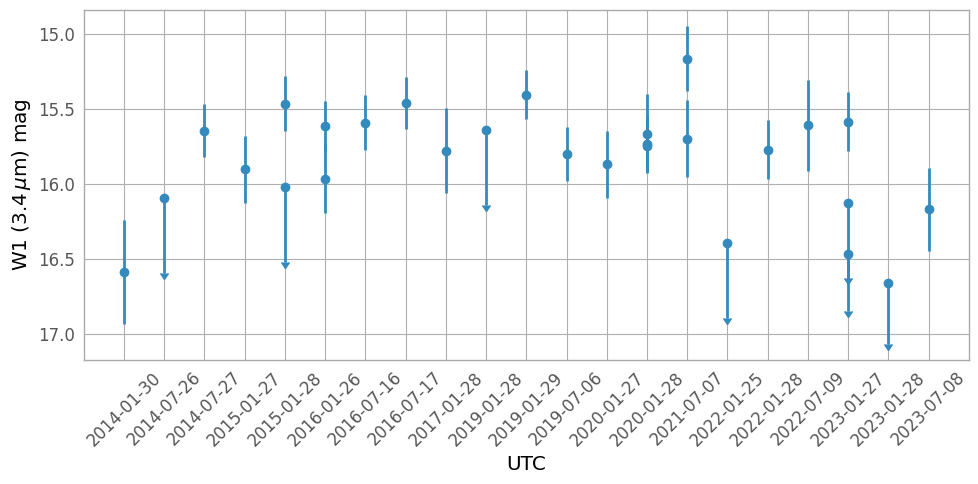

In [160]:
fig, ax = plt.subplots(figsize=(10,5))

plt.gca().invert_yaxis()

# minimize cells like this that are not teaching users. Add text box above stating what the next cell is doing; user can \
# manipulate if they so choose

# 

# now we're going to use ax.errorbar to plot our light curve, where we will use the "Date" column as the x-axis
# the w1 mag as the y-axis (inverted, since brighter sources have lower magnitudes), the error bars will be the error on 
# the w1 mag, and then we will use the upper limit column from our table and the `lolims` keyword to mark the upper limits
ax.errorbar(neo['Date'].to_list(), neo['w1mpro'].to_list(), yerr = neo['w1sigmpro'].tolist(), fmt='o', \
            lolims = neo['UppLim'].to_list(), ecolor=None, elinewidth=2)

ax.tick_params('x', rotation=45)

ax.set_ylabel(r"W1 (3.4$\,\mu \rm{m}$) mag")
ax.set_xlabel('UTC')

plt.tight_layout()
#plt.savefig("transient_NEOWISE.png", dpi=150)
plt.show()


In [ ]:
# Okay, so now we have a potential counterpart within 3'' that is variable over time, and it is a fairly weak signal
# All detections are below 10 sigma, and most are <6.5 sigma. 



In [ ]:
# Run light curve tests for this new transient source


In [ ]:
# reun eregionanalyse for the various observations?

In [190]:
%%capture ereg_output
# here we are using the magic function `%%capture` to store the output of this 
# cell under the variable `ereg_output`. Unfortunately, eregionanalyse does not \
# have a build-in method of storing the output... as it is built, the output is 
# only given in the command line or (in the case of pySAS) in the output of a cell

# adding in some eregionanalyse commands here that we will manipulate further

# for the full band
science_image = 'pn_0p3-10.fits'
inputtable = 'pn_cl.fits' 
inargs = {'imageset'        : science_image, 
          'bkgimageset'     : science_image,
          'srcexp'          : "'(RA,DEC) in CIRCLE(196.3103384,-49.5530939,0.00555)'",
          'exposuremap'     : str(inputtable[0:2:1])+'_expmap_0p3-10.fits'}

MyTask('eregionanalyse', inargs).run()
 

In [191]:
with open('reg_stats_0p3-10keV.txt', 'w') as f:
    f.write(ereg_output.stdout)


In [192]:
# And if you're curious to see the output here for manual inspection, you can simply
# run the command again:

# for the full band
science_image = 'pn_0p3-10.fits'
inputtable = 'pn_cl.fits' 
inargs = {'imageset'        : science_image, 
          'bkgimageset'     : science_image,
          'srcexp'          : "'(RA,DEC) in CIRCLE(196.3103384,-49.5530939,0.00555)'",
          'exposuremap'     : str(inputtable[0:2:1])+'_expmap_0p3-10.fits'}

MyTask('eregionanalyse', inargs).run()
 

Executing: 
eregionanalyse imageset='pn_0p3-10.fits' bkgimageset='pn_0p3-10.fits' exposuremap='pn_expmap_0p3-10.fits' srcexp='(RA,DEC) in CIRCLE(196.3103384,-49.5530939,0.00555)' backexp='NotSet' backval='0' ulsig='0.954' psfmodel='ELLBETA' centroid='yes' xcentroid='0' ycentroid='0' optradius='0' optellipxrad='0' optellipyrad='0' optelliprot='0' srccnts='0' status='yes' withoutputfile='no' output='output.txt'
eregionanalyse:- Executing (routine): eregionanalyse imageset=pn_0p3-10.fits bkgimageset=pn_0p3-10.fits exposuremap=pn_expmap_0p3-10.fits srcexp='(RA,DEC) in CIRCLE(196.3103384,-49.5530939,0.00555)' backexp=NotSet backval=0 ulsig=0.954 psfmodel=ELLBETA centroid=yes xcentroid=0 ycentroid=0 optradius=0 optellipxrad=0 optellipyrad=0 optelliprot=0 srccnts=0 status=yes output=output.txt withoutputfile=no  -w 1 -V 2
eregionanalyse:-  input region centre: 196.30874 -49.552159
counts in source region: 4525
src region cnts per pixel: 59.539474
exposure time: 69812.969
xcentroid: 29151.703


In [193]:
%%capture ereg_output

# for the soft band now
science_image = 'pn_0p3-2.fits'
inputtable = 'pn_cl.fits' 
inargs = {'imageset'        : science_image, 
          'bkgimageset'     : science_image,
          'srcexp'          : "'(RA,DEC) in CIRCLE(196.3103384,-49.5530939,0.00555)'",
          'exposuremap'     : str(inputtable[0:2:1])+'_expmap_0p3-2.fits'}

MyTask('eregionanalyse', inargs).run()



In [194]:
with open('reg_stats_0p3-2keV.txt', 'w') as f:
    f.write(ereg_output.stdout)


In [195]:
%%capture ereg_output

# for the hard band now
science_image = 'pn_2-10.fits'
inputtable = 'pn_cl.fits' 
inargs = {'imageset'        : science_image, 
          'bkgimageset'     : science_image,
          'srcexp'          : "'(RA,DEC) in CIRCLE(196.3103384,-49.5530939,0.00555)'",
          'exposuremap'     : str(inputtable[0:2:1])+'_expmap_2-10.fits'}

MyTask('eregionanalyse', inargs).run()


In [196]:
with open('reg_stats_2-10keV.txt', 'w') as f:
    f.write(ereg_output.stdout)


In [200]:
position = SkyCoord(196.3103384, -49.5530939, frame='icrs', unit="deg")

# we're going to use a 30'' match tolerance to get a sense for what the field looks like in terms of mid-IR sources nearby
# and here instead of using the AllWISE point source catalog ('allwise_p3as_psd'), we're going to search the NEOWISE Single Exposure 
# (L1b) Source Table ('neowiser_p1bs_psd') 
neo = Irsa.query_region(coordinates=position, spatial='Cone', catalog='ztf_objects_dr23', radius=10*u.arcsec)
neo = neo.to_pandas()
#neo = neo[['ra', 'dec', 'sigra', 'sigdec', 'sigradec', 'w1mpro', 'w1sigmpro', 'w1snr', 'w1rchi2', 'w2mpro',\
#           'w2sigmpro', 'w2snr', 'w2rchi2', 'rchi2', 'cc_flags', 'ph_qual', 'mjd']] # limiting to specific columns


# Now, NGC 4945 is in the southern hemisphere, so ZTF
neo

,cntr,oid,ra,dec,htm20,field,ccdid,qid,fid,filtercode,x,y,z,ngoodobs,ngoodobsrel,nobs,nobsrel,refchi,refmag,refmagerr,refsharp,refsnr,astrometricrms,chisq,con,lineartrend,magrms,maxmag,maxslope,meanmag,medianabsdev,medianmag,medmagerr,minmag,nabovemeanbystd_1,nabovemeanbystd_3,nabovemeanbystd_5,nbelowmeanbystd_1,nbelowmeanbystd_3,nbelowmeanbystd_5,nconsecabovemeanbystd_1,nconsecabovemeanbystd_3,nconsecabovemeanbystd_5,nconsecbelowmeanbystd_1,nconsecbelowmeanbystd_3,nconsecbelowmeanbystd_5,nconsecfrommeanbystd_1,nconsecfrommeanbystd_3,nconsecfrommeanbystd_5,nmedianbufferrange,npairposslope,percentiles_05,percentiles_10,percentiles_175,percentiles_25,percentiles_325,percentiles_40,percentiles_60,percentiles_675,percentiles_75,percentiles_825,percentiles_90,percentiles_95,skewness,smallkurtosis,stetsonj,stetsonk,vonneumannratio,weightedmagrms,weightedmeanmag


### 3.2: Source and background region selection

Suppose you are interested in the source at the aimpoint of this observation (RA: X, Dec: X). We will now work to assign a source region and a background region to use when generating spectra as well as running science tasks like eregionanalyse


How does one choose an aperture size for the source? <a href='https://xmm-tools.cosmos.esa.int/external/xmm_user_support/documentation/uhb/onaxisxraypsf.html'> We can look at the characteristics of the on-axis PSF of the EPIC detectors</a>

Note, as you move off-axis, you will have smaller and smaller EEFs for the same aperture size; in order to enclose more of the source emission, you would need to increase the size of your aperture.


As you may have noticed during the Stage 2 processing steps above, the PSF shapes change slightly between the different cameras. In particular, don't be alarmed if your mos2 imaging shows triangular point sources, as the the mos2 PSF is known to have this triangular shape



From the pn, mos1, and mos2 encircled energy fraction plots (also referred to as enclosed energy fraction, or EEF), we see that @1.5 keV, @5 keV, and @9 keV, 85-90%, X-X%, and X-X% of the energy is enclosed within a region 30'' in radius for pn
where the enclosed energy fraction drops with increasing energy naturally as a result of the decreasing effective area at higher energies, illustrated with the plot below:

For mos1 and mos2, the EEF curves are somewhat similar showing.....

Therefore, a reasonable choice for a source extraction aperture is 30''. The sample the background we will adopt a large circular region 60'' in radius; note we could also use a variety of regions, including multiple circular regions, rectangles and other polygons, as well as annuli.



In [ ]:
# Here we will include some notes about the characteristics of XMM and the imaging
# such as PSF size, shape, EEF as a function of off-axis angle, etc.


# include link to the documentation as well as some screengraps of the PSF sizes from the webpage





In [ ]:
# now the user should go and assign a source and background region for use in spectral extraction
# we will be generating a source and background regions with the following parameters:
# source: RA = , Dec = , radius = 
# background: RA = , Dec = , radius =  
# both regions are simple circles, but users can use a variety of regions. See Chapter X in the XMM SAS manual.


# note, we're having an issue with saving region files to the sciserver directory... need to figure out how to get that to work before 
# we can proceed with the spectral extraction



In [ ]:
# now we will begin extracting the spectra from the source and background regions
sou = ['sou.reg']
bkg_pn = ['bkg_pn.reg']
bkg_mos1 = ['bkg_mos1.reg']
bkg_mos2 = ['bkg_mos2.reg']

# we use lists above and a for loop below to automatically extract the spectra for an abritrary number of sources

#for source, backpn, backmos1, backmos2 in zip(sou, bkg_pn bkg_mos1 bkg_mos2):
    # code goes here



In [ ]:
#inputtable = 'pn_cl.fits' 
#camera = inputtable[:-8:1]
#
#print(camera)

In [ ]:
# assigning the spectroscopic files here

with open('sou.reg') as f:
    lines = f.readlines()
    sou = lines[0][:-2:1]+',X,Y)'

with open('bkg_pn.reg') as f:
    lines = f.readlines()
    bkg_pn = lines[0][:-2:1]+',X,Y)'


# --> WE NEED TO GENERATE REGION FILES SO THE USER CAN ACTUALLY USE THIS AS AN EXAMPLE
# IF THEY NEED ONE!

# # Extracting the EPIC spectrum(a) here:
# printf "\n\n\n#----------------------------------------------------------------------#"
# printf "\n\nNow extracting the ${ARG1} spectrum for ${ARG3}...\n"
# printf "Note, we are not filtering at this step because the cleaned pn image was already cleaned for hot pixels, background events, bad patterns (<=4).\n\n"
# printf "#----------------------------------------------------------------------#\n\n\n"

In [46]:
# now running evselect to extract the spectral files for the source

sou = 'circle(25567.61,23871.12,600.00,X,Y)&&(PATTERN == 0)' #&&(PATTERN == 0)
bkg_pn = 'circle(21815.79,29471.74,1200.00,X,Y)&&(PATTERN == 0)' #&&(PATTERN == 0)
bkg_mos1 = 'circle(21815.79,29471.74,1200.00,X,Y)&&(PATTERN == 0)' #&&(PATTERN == 0)
bkg_mos2 = 'circle(21815.79,29471.74,1200.00,X,Y)&&(PATTERN == 0)' #&&(PATTERN == 0)

# NOTE: in some cases, it may be necessary to use unique background regions across
# pn, mos1, and mos2 (for example, if the background region adopted for pn falls on top of a CCD
# that has been toggled off in mos1 or mos2, we would need to assign a different background region for mos1

# for simplicity here, we will assume the pn, mos1, and mos2 background regions to be identical, but again this need not always be the case

# Ryan: check this....
# As per the SAS manual, the optimal background region placement will have it on the same
# physical X/Y value???? as the source. Check the manual, there is something about
# having them be on the same line of x or y pixels or something...

pnchanmax = '20479'
moschanmax = '11999'

# running first on pn
inputtable = 'pn_cl.fits' 
camera = inputtable[:-8:1]
inargs = {'table'           : inputtable, 
          'withspectrumset' : 'yes',
          'spectrumset'     : "'sou-'"+camera+"'.fits'",
          'energycolumn'    : 'PI',
          'spectralbinsize' : '5',
          'withspecranges'  : 'yes',
          'specchannelmin'  : '0', 
          'specchannelmax'  : pnchanmax,
          'expression'      : str(sou)}

#{'options':'--verbosity 4'}

MyTask('evselect', inargs).run()


# and now running the background spectrum extraction
inargs = {'table'           : inputtable, 
          'withspectrumset' : 'yes',
          'spectrumset'     : 'sou-bkg-'+camera+'.fits',
          'energycolumn'    : 'PI',
          'spectralbinsize' : '5',
          'withspecranges'  : 'yes',
          'specchannelmin'  : '0', 
          'specchannelmax'  : pnchanmax,
          'expression'      : str(bkg_pn)}

MyTask('evselect', inargs).run()



# and now running evselect to extract the source and background spectra 
# for mos1 and mos2
inputtables = ['mos1_cl.fits', 'mos2_cl.fits']
mos_bkgs = [bkg_mos1, bkg_mos1]
for i, bkg_mos in zip(inputtables,mos_bkgs):
    camera = i[:-8:1]
    # first for mos1/mos2 source spectra
    inargs = {'table'           : i, 
              'withspectrumset' : 'yes',
              'spectrumset'     : "'sou-'"+camera+"'.fits'",
              'energycolumn'    : 'PI',
              'spectralbinsize' : '5',
              'withspecranges'  : 'yes',
              'specchannelmin'  : '0', 
              'specchannelmax'  : moschanmax,
              'expression'      : str(sou)}
    
    #{'options':'--verbosity 4'}
    
    MyTask('evselect', inargs).run()

    # and now for mos1/mos2 background spectra
    inargs = {'table'           : i, 
              'withspectrumset' : 'yes',
              'spectrumset'     : 'sou-bkg-'+camera+'.fits',
              'energycolumn'    : 'PI',
              'spectralbinsize' : '5',
              'withspecranges'  : 'yes',
              'specchannelmin'  : '0', 
              'specchannelmax'  : moschanmax,
              'expression'      : str(bkg_mos)}
    
    MyTask('evselect', inargs).run()

#--> Do I need the following like in Ryan's code?:
##           'withfilteredset' : 'yes',
##           'filteredset'     : filtered_source,
##           'keepfilteroutput': 'yes',
##           'filtertype'      : 'expression',

# pulled from Ryan's notebook for reference:
# filtered_source = 'mos1_filtered.fits'
# filtered_bkg = 'bkg_filtered.fits'
# source_spectra_file = 'mos1_pi.fits'
# bkg_spectra_file = 'bkg_pi.fits'
# filtered_event_list = 'filtered_event_list.fits'
# 
# inargs = {'table'           : filtered_event_list,
#           'energycolumn'    : 'PI',
#           'withfilteredset' : 'yes',
#           'filteredset'     : filtered_source,
#           'keepfilteroutput': 'yes',
#           'filtertype'      : 'expression',
#           'expression'      : "'((X,Y) in CIRCLE(26188.5,22816.5,300))'",
#           'withspectrumset' : 'yes',
#           'spectrumset'     : source_spectra_file,
#           'spectralbinsize' : '5',
#           'withspecranges'  : 'yes',
#           'specchannelmin'  : '0',
#           'specchannelmax'  : '11999'}
# 
# MyTask('evselect', inargs).run()




## Extracting the EPIC pn spectrum:
#printf "\n\n\n#----------------------------------------------------------------------#"
#printf "\n\nNow extracting the pn spectrum...\n"
#printf "Note, we are not filtering at this step because the cleaned pn image was already cleaned for hot pixels, background events, bad patterns (<=4), and irrelevant CCDs.\n\n"
#printf "#----------------------------------------------------------------------#\n\n\n"



pysas.sastask - WARNING  - No need to include withspecranges. Assumed withspecranges=yes
Executing: 
evselect table='pn_cl.fits' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='circle(25567.61,23871.12,600.00,X,Y)&&(PATTERN == 0)' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PI' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='no' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='yes' spectrumset='sou

### For reference, the equivalent commands in SAS for these actions are:

`source="$(cat ${ARG3}.fits)" # Storing the source parameters here`

`source="${source%?},X,Y)"    # Adding in 'X,Y)' so that the format is correct.`

`bkg="$(cat ${ARG4}.fits)" # Storing the bkg parameters here`

`bkg="${bkg%?},X,Y)"    # Adding in 'X,Y)' so that the format is correct.`

`# Now extracting the source spectrum...`

`evselect table=${ARG1}.fits withspectrumset=yes spectrumset=${ARG3}-${ARG2}.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=${ARG5} expression="${source}"`

`# Now extracting the background spectrum...`

`evselect table=${ARG1}.fits withspectrumset=yes spectrumset=${ARG3}-bkg-${ARG2}.fits  energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=${ARG5} expression="${bkg}"`


ARG1="evpn_U027a-cl1"

ARG2="evpn_U027"

ARG3="sou_SOI2"

ARG4="bkg1"

ARG5="20479"

`ARG1="$1" # This is the full cleaned file name (minus .fits)`

`ARG2="$2" # This is the cleaned image`

`ARG3="$3" # This is the source choice`

`ARG4="$4" # This is the bkg choice`

`ARG5="$5" # This is the max channel number (needed because pn and mos have different max values)`



In [48]:
# Now writing the bkg/source area in the header 

# first for pn
inputtable = 'pn_cl.fits' 
camera = inputtable[:-8:1]

# first for the source spectrum
inargs = {'spectrumset'     : 'sou-'+camera+'.fits',
          'badpixlocation'  : inputtable}

MyTask('backscale', inargs).run()

# and now for the background spectrum
inargs = {'spectrumset'     : 'sou-bkg-'+camera+'.fits',
          'badpixlocation'  : inputtable}

MyTask('backscale', inargs).run()


# now to rinse and repeat for mos1 and mos2
inputtables = ['mos1_cl.fits', 'mos2_cl.fits']
for i in inputtables:
    camera = i[:-8:1]
    # first for the mos1/mos2 source spectrum
    inargs = {'spectrumset'     : 'sou-'+camera+'.fits',
              'badpixlocation'  : i}
    #
    MyTask('backscale', inargs).run()
    #
    # and now for the mos1/mos2 background spectrum
    inargs = {'spectrumset'     : 'sou-bkg-'+camera+'.fits',
              'badpixlocation'  : i}
    #
    MyTask('backscale', inargs).run()



Executing: 
backscale spectrumset='sou-pn.fits' badpixlocation='pn_cl.fits' withbadpixcorr='yes' useodfatt='no' ignoreoutoffov='yes' withbadpixres='no' badpixelresolution='2'
backscale:- Executing (routine): backscale spectrumset=sou-pn.fits badpixlocation=pn_cl.fits withbadpixcorr=yes useodfatt=no ignoreoutoffov=yes badpixelresolution=2 withbadpixres=no  -w 1 -V 2
backscale:- Executing (routine): arfgen spectrumset=sou-pn.fits rmfset=response.ds withrmfset=no arfset=deletearf.ds detmaptype=flat detmaparray=detmapfile.ds: detxoffset=1200 detyoffset=1200 withdetbounds=no detxbins=1 detybins=1 withdetbins=yes psfenergy=2 filterdss=yes filteredset=filteredpixellist.ds withfilteredset=no sourcecoords=eqpos sourcex=0 sourcey=0 withsourcepos=no extendedsource=no modeleffarea=no modelquantumeff=no modelfiltertrans=no modelcontamination=yes modelee=no modelootcorr=yes applyxcaladjustment=yes applyabsfluxcorr=yes eegridfactor=100 withbadpixcorr=yes badpixlocation=pn_cl.fits psfmodel=ELLBETA bad

### As before, for reference the following commands can be used in the terminal to run the backscale command in SAS

`backscale spectrumset=${ARG3}-${ARG2}.fits badpixlocation=${ARG1}.fits  >/dev/null`


`backscale spectrumset=${ARG3}-bkg-${ARG2}.fits badpixlocation=${ARG1}.fits  >/dev/null`


where ARG2 and ARG3 represent your source name and camera name while ARG1 represents the cleaned event file for the camera in question. So, for pn, as an example:

`ARG1=pn_cl`, `ARG2=pn`, and `ARG3=sou`

--> Ryan, come back and simplify. We can combine the use of ARG1 and ARG3!



In [53]:
# and now generating the response files for the spectra

## Creating a new RMF:
#printf "\n\n\n#----------------------------------------------------------------------#"
#printf "\n\nCreating a new rmf file for the ${ARG1} spectrum now...\n\n"
#printf "#----------------------------------------------------------------------#\n\n\n"

# a note to ryan: we need to come back and figure out the most efficient way to make this iterable...


# first pn
inputtable = 'pn_cl.fits' 
camera = inputtable[:-8:1]
inargs = {'spectrumset'     : 'sou-'+camera+'.fits',
          'rmfset'          : 'sou-'+camera+'.rmf'}

MyTask('rmfgen', inargs).run()

# and then the mos1 and mos2 cameras
inputtables = ['mos1_cl.fits', 'mos2_cl.fits']
for i in inputtables:
    camera = i[:-8:1]
    inargs = {'spectrumset'     : 'sou-'+camera+'.fits',
              'rmfset'          : 'sou-'+camera+'.rmf'}

    MyTask('rmfgen', inargs).run()


## Creating a new ARF:
#printf "\n\n\n#----------------------------------------------------------------------#"
#printf "\n\nCreating a new arf file for the ${ARG1} spectrum now...\n\n"
#printf "#----------------------------------------------------------------------#\n\n\n"

inputtable = 'pn_cl.fits' 
camera = inputtable[:-8:1]
inargs = {'spectrumset'     : 'sou-'+camera+'.fits',
          'arfset'          : 'sou-'+camera+'.arf', 
          'withrmfset'      : 'yes',
          'rmfset'          : 'sou-pn.rmf',
          'detmaptype'      : 'psf',
          'badpixlocation'  : i}

MyTask('arfgen', inargs).run()


# and then the mos1 and mos2 cameras
inputtables = ['mos1_cl.fits', 'mos2_cl.fits']
for i in inputtables:
    camera = i[:-8:1]
    inargs = {'spectrumset'     : 'sou-'+camera+'.fits',
              'arfset'          : 'sou-'+camera+'.arf', 
              'withrmfset'      : 'yes',
              'rmfset'          : 'sou-'+camera+'.rmf',
              'detmaptype'      : 'psf',
              'badpixlocation'  : i}
    
    MyTask('arfgen', inargs).run()

# a BIG NOTE to self: I am using detmaptype above as I have seen in the ESA guides.
# Ryan T does not use this, but he does use 'badpixcorr':'yes'
# I do not know why we are using different things at the moment, or if there is 
# a substantial difference.... need to look into this....


Executing: 
rmfgen rmfset='sou-pn.rmf' threshold='1e-06' withenergybins='no' energymin='0' energymax='15' nenergybins='30' spectrumset='sou-pn.fits' format='var' detmaptype='psf' detmaparray='detmapfile.ds:' withdetbounds='no' detxoffset='1200' detyoffset='1200' withdetbins='yes' detxbins='160' detybins='160' correctforpileup='no' raweventfile='rawevents.ds' filterdss='yes' withfilteredset='no' filteredset='filteredpixellist.ds' withrmfset='no' psfenergy='2' withsourcepos='no' sourcecoords='eqpos' sourcex='0' sourcey='0' extendedsource='no' modeleffarea='no' modelquantumeff='no' modelfiltertrans='no' modelcontamination='no' modelee='yes' modelootcorr='no' eegridfactor='100' withbadpixcorr='no' badpixlocation='notSpecified' setbackscale='no' keeparfset='yes' useodfatt='no' ignoreoutoffov='yes' crossregionarf='no' crossreg_spectrumset='' psfmodel='notSpecified' withbadpixres='no' badpixelresolution='2' applyxcaladjustment='no' acceptchanrange='no' applyabsfluxcorr='no'
rmfgen:- Executing

### As before, for reference the following commands allow for the generation of the spectra, response files, and the backscaling of the spectra in terminal with standard SAS:

`# Creating the rmf for the pn spectrum`
`rmfgen spectrumset=${ARG3}-${ARG2}.fits rmfset=${ARG3}-${ARG2}.rmf    >/dev/null` 

`#Creating the arf for the pn spectrum`
`arfgen spectrumset=${ARG3}-${ARG2}.fits arfset=${ARG3}-${ARG2}.arf withrmfset=yes rmfset=${ARG3}-${ARG2}.rmf detmaptype=psf badpixlocation=${ARG1}.fits   >/dev/null`   

`#extendedsource=no modelee=true`

where again ARG1, ARG2, and ARG3 represent the cleaned event file name, source designation, and the camera+exposure number(?), respectively. As an example, for pn these would be: 

`ARG2="pn_cl"`

`ARG2="pn"`

`ARG3="sou"`






In [ ]:

# I need to go back and see if we were extracting spectra from patterns<=4 or patterns==0. I think it's supposed to only be ==0.


In [ ]:
# note that if you have an arbitrary number of sources, you can run these commands in sequence using a simply for loop once you have added the region files and any additional information to lists
# that you will pass to those commands, like so:

# here we'll adopt two other source regions and background regions in addition to the one above, so three sources in total that we want to extract spectra from. 



# inset commands here





### 3.4: Generating Source Statistics via eregionalyse

Now supppose in addition to (or instead of spectra) you were only interested in obtaining the positional and photometric characteristics of your source. For this, we turn to the SAS task eregionalyse. 


--> Discuss querks of eregionanalyse here and motivate why it is great to run with pySAS. 




In [ ]:
# ARG1="$1" # cleaned science file in question
# ARG2="$2" # Source ID
# ARG3="$3" # input RA
# ARG4="$4" # input Dec

# mkdir Source_detection/eregfiles_${ARG1}
# # This is for 20''
# eregionanalyse imageset=${ARG1}.fits bkgimageset=${ARG1}bkg.fits srcexp="(RA,DEC) in CIRCLE("${ARG3}","${ARG4}",0.005555)" exposuremap=${ARG1}exp.fits > Source_detection/eregfiles_${ARG1}/sou${ARG2}.txt
# #eregionanalyse imageset=evpn_U027_0p3-10.fits bkgimageset=evpn_U027_0p3-10.fits srcexp="(X,Y) in CIRCLE($ARG2,$ARG3,600)" exposuremap=evpn_U027_expmap_0p3-10.fits > eregfiles/sou${ARG2}.txt


In [ ]:
# now suppose you are interested in detecting a series of sources across the field of view, we will now run the edetectchain command
# on our cleaned event file. Once this is done, we will also plot the region list from the PPS directory to compare the results (which \
# should be similar)




In [ ]:
# now we will plot the extracted spectra from our observation via XSpec and display it in matplotlib for inspection
# Note we will have three spectra for any one object observed with XMM-Newton, since there are three cameras on board (pn, mos1, and mos2)



In [ ]:

def store_plot_data():
    Plot.device = '/null'
    Plot.setRebin(5,100)
    Plot('ufspec')
    # now focusing on the actual spectrum part of the plot and fit
    #for i in range(len()):  #--> I'll add this in once I figure out how to read out the number of data objects
    #Assigning spectrum plot group for data set #1
    (energies1, energies1err) = Plot.x(plotGroup=1), Plot.xErr(plotGroup=1)
    (flux1, flux1err) = Plot.y(plotGroup=1), Plot.yErr(plotGroup=1)
    folded1 = Plot.model(plotGroup=1)
    #Assigning spectrum plot group for data set #2
    (energies2, energies2err) = Plot.x(plotGroup=2), Plot.xErr(plotGroup=2)
    (flux2, flux2err) = Plot.y(plotGroup=2), Plot.yErr(plotGroup=2)
    folded2 = Plot.model(plotGroup=2)
    #Assigning spectrum plot group for data set #3
    (energies3, energies3err) = Plot.x(plotGroup=3), Plot.xErr(plotGroup=3)
    (flux3, flux3err) = Plot.y(plotGroup=3), Plot.yErr(plotGroup=3)
    folded3 = Plot.model(plotGroup=3)
    # Now focusing on the ratio aspect of the plot
    Plot('rat')
    #Assigning ratio plot group for data set #1
    (rat1, rat1err) = Plot.x(plotGroup=1), Plot.xErr(plotGroup=1)
    (fluxr1, fluxr1err) = Plot.y(plotGroup=1), Plot.yErr(plotGroup=1)
    #Assigning ratio plot group for data set #2
    (rat2, rat2err) = Plot.x(plotGroup=2), Plot.xErr(plotGroup=2)
    (fluxr2, fluxr2err) = Plot.y(plotGroup=2), Plot.yErr(plotGroup=2)
    #Assigning ratio plot group for data set #3
    (rat3, rat3err) = Plot.x(plotGroup=3), Plot.xErr(plotGroup=3)
    (fluxr3, fluxr3err) = Plot.y(plotGroup=3), Plot.yErr(plotGroup=3)
    return energies1, energies1err, flux1, flux1err, folded1, energies2, energies2err, flux2, flux2err, folded2, energies3, energies3err, flux3, flux3err, folded3, rat1, rat1err, fluxr1, fluxr1err, rat2, rat2err, fluxr2, fluxr2err, rat3, rat3err, fluxr3, fluxr3err


def plot_params():
    plt.rcParams.update({'font.size': 12})
    # Plotting the data (errors bars and open circles for each):
    im = ax1.errorbar(energies1, flux1, yerr=flux1err, xerr=energies1err, c='royalblue', elinewidth=1, fmt=',', alpha=0.8, label='EPIC PN')
    im2 = ax1.errorbar(energies2, flux2, yerr=flux2err, xerr=energies2err, c='tab:orange', elinewidth=1, fmt=',', alpha=0.8, label='EPIC MOS1')
    im3 = ax1.errorbar(energies3, flux3, yerr=flux3err, xerr=energies3err, c='forestgreen', elinewidth=1, fmt=',', alpha=0.8, label='EPIC MOS2')
    # Plotting the models
    im1 = ax1.plot(energies1, folded1, c='black', linestyle = '-', alpha=0.8, label='_nolegend_')     #FPMA Model
    im2 = ax1.plot(energies2, folded2, c='black', linestyle = '--', alpha=0.8, label='_nolegend_')    #FPMB Model
    im3 = ax1.plot(energies3, folded3, c='black', linestyle = '-.', alpha=0.8, label='_nolegend_')    #XMM PN Model
    ## Plotting the component models 
    #im1 = ax1.plot(energies1, comps1, c='black', linestyle = '..', alpha=0.5, label='_nolegend_')     #FPMA Model
    #im2 = ax1.plot(energies2, comps2, c='black', linestyle = '..', alpha=0.5, label='_nolegend_')    #FPMB Model
    #im3 = ax1.plot(energies3, comps3, c='black', linestyle = '..', alpha=0.5, label='_nolegend_')    #XMM PN Model
    # Plotting the ratios
    im = ax2.errorbar(rat1, fluxr1, yerr=fluxr1err, xerr=rat1err, elinewidth=1, c='royalblue', fmt=',', alpha=0.8, label='EPIC PN')
    im2 = ax2.errorbar(rat2, fluxr2, yerr=fluxr2err, xerr=rat2err, c='tab:orange', fmt=',', alpha=0.8, label='EPIC MOS1')
    im3 = ax2.errorbar(rat3, fluxr3, yerr=fluxr3err, xerr=rat3err, c='forestgreen', fmt=',', alpha=0.8, label='EPIC MOS1')
    ax2.hlines(1.0, 0.3, 15.0, 'black', linestyles='dotted') # Plotting a zero line here...
    ax2.set_xscale('log')
    ax2.set(xlabel='Energy (keV)', ylabel='Ratios')
    #ax1.text(0.09, 0.92, name, transform=ax1.transAxes)
    ax1.set_xlabel('')
    ax1.tick_params(labelbottom=False, bottom=False, top=False)    
    ax1.set(ylabel='Photons cm$^{-2}$ s$^{-1}$ keV$^{-1}$') #xlabel='Energy (keV)',
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.set_ylim(10**-7,2*10**-4)
    ax2.set_ylim(-0.5,2.5)
    ax1.set_xlim(0.3,8)
    ax2.set_xlim(0.3,8)
    ax1.legend(loc='upper right', prop={'size': 10})
    ax2.tick_params(top=True, which='both', direction='in')
    #plt.subplots_adjust(hspace=0.02)


In [ ]:
Xset.abund = "wilm"

os.chdir("../XMM/0903540101/work")
AllData("1:1 " + "sou_SOI2-evpn_U027-grp1.fits") # for xmm pn
AllData("2:2 " + "sou_SOI2-evm1_U004-grp1.fits") # for xmm mos1
AllData("3:3 " + "sou_SOI2-evm2_U004-grp1.fits") # for xmm mos2
pn = AllData(1)
mos1 = AllData(2)
mos2 = AllData(3)

pn.background = "sou_SOI2-bkg3-evpn_U027.fits"
mos1.background = "sou_SOI2-bkg3-evm1_U004.fits"
mos2.background = "sou_SOI2-bkg3-evm2_U004.fits"


In [ ]:
pn.ignore("**-0.3 7.0-**")
mos1.ignore("**-0.3 7.0-**")
mos2.ignore("**-0.3 7.0-**")
AllData.ignore("bad")

# Now for plotting
Plot.device = "/xw"
Plot.xAxis = "keV"
Plot.yLog  = True
#Plot.setRebin(1,100) # Then we'll ask the user if this is good enough. If not, will
                     # prompt user for input.
#Plot.show()
Plot.setRebin(5,100)
Plot("data")


In [ ]:
# link to notebooks and details on fitting with pyxspec

## Summary and concluding remarks

In this tutorial notebook, we have now performed an end-to-end reprocessing and cleaning of an XMM-Newton observation as well as generated science-ready data products such as spectra, science images, source lists, and extracted photometry. Congratulations! You are now prepared to prepare and process how ever many more observations you require for your science case, as well as embark on your scientific analysis! 


## Additional recommended reading and resources
Description here
- item
- item
- item
- item



### XMM ABC Guide Notebooks:
- item
- item
- item
- item


### PyXSpec tutorials
- item
- item
- item
- item



### X-ray Spectroscopic Fitting tutorials by Dr. Peter Boorman, using the Bayesian X-ray Analysis Software [external]
- item
- item
- item
- item



In [ ]:
# similarly, we will pull in the function for generating a light curve, which will be useful during the Stage 2 background light curve cleaning and selection of good time intervals.

def plot_light_curve(event_list_file, light_curve_file='ltcrv.fits'):
                     
    inargs = {'table'          : event_list_file, 
              'withrateset'    : 'yes', 
              'rateset'        : light_curve_file, 
              'maketimecolumn' : 'yes', 
              'timecolumn'     : 'TIME', 
              'timebinsize'    : '100', 
              'makeratecolumn' : 'yes'}

    MyTask('evselect', inargs).run()

    ts = Table.read(light_curve_file,hdu=1)
    plt.scatter(ts['TIME'],ts['RATE'])
    plt.xlabel('Time (s)')
    plt.ylabel('Count Rate (ct/s)')
    plt.show()

In [ ]:
plot_light_curve(filtered_event_list,light_curve_file=light_curve_file)